In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qn '/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/yolo_plate_ocr_dataset.zip'

In [ ]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import os
import shutil

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torchmetrics.detection import MeanAveragePrecision

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class PlateOCRDataset(Dataset):
  def __init__(self, images_folder, labels_folder, transform=None):
    self.images_folder = images_folder
    self.labels_folder = labels_folder
    self.transform = transform

    self.image_files = sorted(os.listdir(self.images_folder))

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    image_file = self.image_files[index]
    label_file = os.path.join(self.labels_folder, image_file[:-4] + '.txt')

    image = Image.open(os.path.join(self.images_folder, image_file))
    image_width, image_height = image.size

    image = np.array(image, dtype='float32') / 255.0
    target = self.get_target(label_file, image_width, image_height)

    if self.transform:
      augmented = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
      image = augmented['image']
      target['boxes'] = torch.tensor(augmented['bboxes'], dtype=torch.float)
      target['labels'] = torch.tensor(augmented['labels'])

    return image, target

  def xywh_to_xyxy(self, box, image_width, image_height):
    category = int(box[0])

    x1 = int((float(box[1]) - float(box[3])/2)* image_width)
    y1 = int((float(box[2]) - float(box[4])/2) *image_height)
    x2 = x1 + int(float(box[3]) * image_width)
    y2 = y1 + int(float(box[4]) * image_height)

    # x1 = float(box[1]) - float(box[3])/2
    # y1 = float(box[2]) - float(box[4])/2
    # x2 = x1 + float(box[3])
    # y2 = y1 + float(box[4])

    return [category, x1, y1, x2, y2]

  def get_target(self, label_file, image_width, image_height):
    with open(os.path.join(self.labels_folder, label_file), 'r') as f:
      boxes = f.readlines()

    target = {}
    labels = []
    bboxes = []

    for box in boxes:
      box = box[:-2].split()
      box = self.xywh_to_xyxy(box, image_width, image_height)
      labels.append(box[0] + 1) #for resnet50 classes start with 1, not 0
      bboxes.append(box[1:])

    if len(bboxes) == 0:
      bboxes.append([0, 0, image_width,image_height])
      labels.append(0)
    target['boxes'] = bboxes
    target['labels'] = labels

    return target

In [ ]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [ ]:
train_transform = A.Compose(
    [
      A.Rotate(limit=10, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.5),
      A.Resize(224, 224),
      ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']
    )
)


test_transform = A.Compose(
    [
      A.Resize(224, 224),
      ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']
    )
)

In [ ]:
df_train = PlateOCRDataset('/content/yolo_plate_ocr_dataset/images/train', '/content/yolo_plate_ocr_dataset/labels/train', transform=train_transform)
df_val = PlateOCRDataset('/content/yolo_plate_ocr_dataset/images/val', '/content/yolo_plate_ocr_dataset/labels/val', transform=train_transform)
df_test = PlateOCRDataset('/content/yolo_plate_ocr_dataset/images/test', '/content/yolo_plate_ocr_dataset/labels/test', transform=train_transform)

train_loader = DataLoader(df_train, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(df_val, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(df_test, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [ ]:
images, labels = next(iter(train_loader))
labels

({'boxes': tensor([[ 50.1053,  27.2000,  76.0421,  98.8000],
          [ 78.4000,  28.4000,  99.9158, 102.8000],
          [129.0947,  37.2000, 157.9789, 110.0000],
          [158.8632,  42.4000, 184.5053, 112.4000],
          [ 24.7579, 105.6000,  51.8737, 175.6000],
          [ 58.9474, 107.2000,  82.2316, 180.0000],
          [ 92.8421, 112.8000, 118.1895, 183.2000],
          [135.8737, 118.8000, 161.2211, 192.0000],
          [169.4737, 124.4000, 193.3474, 195.6000]]),
  'labels': tensor([ 9,  5, 17,  2,  3,  3,  6, 10,  4])},
 {'boxes': tensor([[ 45.9789,  30.4000,  69.2632, 103.6000],
          [ 73.0947,  33.6000,  94.9053, 104.8000],
          [124.9684,  38.0000, 147.9579, 108.0000],
          [152.6737,  36.0000, 170.0632, 107.6000],
          [ 27.1158, 118.8000,  51.8737, 193.2000],
          [ 58.9474, 121.2000,  82.2316, 194.0000],
          [ 93.7263, 122.4000, 113.7684, 193.2000],
          [135.8737, 122.4000, 156.2105, 192.4000],
          [168.0000, 121.6000, 189.51

In [ ]:
from torchvision.utils import draw_bounding_boxes

def plot_sample_images():
  images, targets = next(iter(train_loader))

  fig, ax = plt.subplots(4, 2, figsize=(15, 20))
  for i in range(4):
    # image0 = draw_bounding_boxes((images[2*i] * 255.0).to(torch.uint8),
    #                              targets[2*i]['boxes'].to(torch.int),
    #                              targets[2*i]['labels'].to(torch.int))
    # image1 = draw_bounding_boxes((images[2*i+1] * 255.0).to(torch.uint8),
    #                              targets[2*i+1]['boxes'].to(torch.int),
    #                              targets[2*i+1]['labels'].to(torch.int))
    ax[i, 0].imshow(images[2*i].permute(1, 2, 0).numpy())
    ax[i, 1].imshow(images[2*i+1].permute(1, 2, 0).numpy())

  plt.tight_layout()
  plt.show()

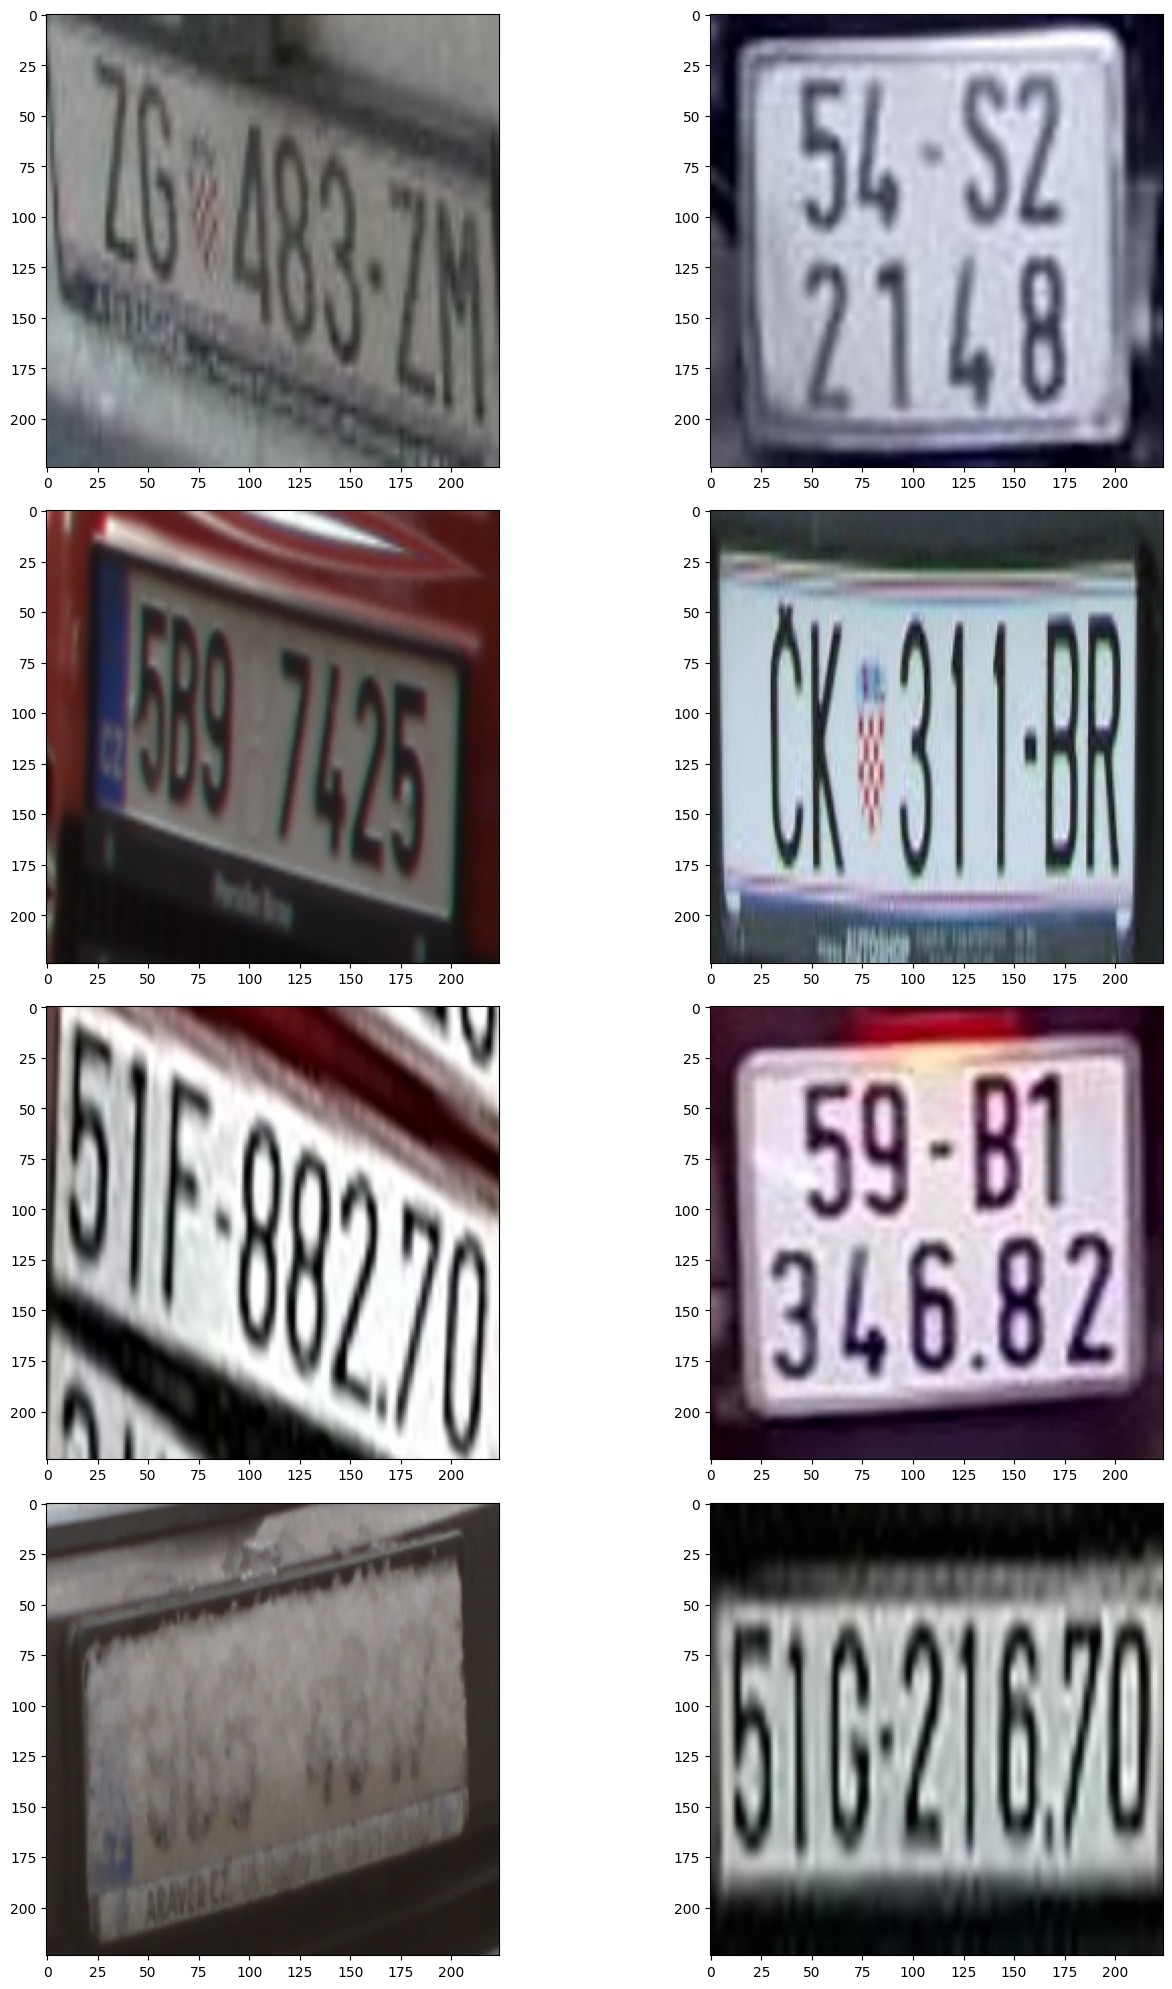

In [ ]:
plot_sample_images()

In [ ]:
import torchvision
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models.detection import FasterRCNN, fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

def get_model(num_classes):
  backbone = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT).features
  backbone.out_channels=960

  anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256),),
    aspect_ratios=((1.0, 2.0),)
  )

  roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
  )

  model = FasterRCNN(
      backbone=backbone,
      num_classes=num_classes,
      rpn_anchor_generator=anchor_generator,
      box_roi_pool=roi_pooler
  )

  return model

In [ ]:
#get model and freeze all the layers except for the last layers (rpn and roi_heads)
model = get_model(37)

for name, param in model.named_parameters():
  if 'backbone' in name:
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 120MB/s] 


In [ ]:
def train_one_epoch(model, loader, device, optimizer, scheduler=None):
  model.train()
  train_loss = 0.0

  for images, labels in tqdm(loader):
    images = [image.to(device) for image in images]
    labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

    losses = model(images, labels)
    loss = sum(losses.values())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if scheduler:
      scheduler.step()

    train_loss += loss.item()

  train_loss /= len(loader)
  return train_loss

In [ ]:
def apply_nms(preds, score_threshold, iou_threshold):
  for pred in preds:
    boxes, scores, labels = pred['boxes'], pred['scores'], pred['labels']
    indices = torch.nonzero(scores > score_threshold).squeeze(1)
    boxes = boxes[indices]
    scores = scores[indices]
    labels = labels[indices]

    indices = torchvision.ops.nms(boxes, scores, iou_threshold)
    pred['boxes'] = boxes[indices]
    pred['scores'] = scores[indices]
    pred['labels'] = labels[indices]
  return preds

def test_one_epoch(model, loader, device, score_threshold, iou_threshold):
  model.eval()
  metric = MeanAveragePrecision(iou_type='bbox')

  for images, labels in tqdm(loader):
    images = [image.to(device) for image in images]
    labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

    with torch.no_grad():
      preds = model(images)
      print('preds before nms', preds)
      preds = apply_nms(preds, score_threshold, iou_threshold)
      print('preds after nms', preds)
      metric.update(preds, labels)

  metric.compute()
  return metric


In [ ]:
def train(num_epochs, model, train_loader, val_loader, device, optimizer, frozen_layers=True, scheduler=None):
  train_losses = []
  metric_values = []
  score_threshold = 0.7
  iou_threshold = 0.5

  for epoch in range(num_epochs):

    print(f'epoch: {epoch}')

    train_loss = train_one_epoch(model, train_loader, device, optimizer, scheduler)
    metric_value = test_one_epoch(model, val_loader, device, score_threshold, iou_threshold)
    train_losses.append(train_loss)
    metric_values.append(metric_value)
    print(f'train loss: {train_loss}')

    if len(train_losses) > 2 and train_losses[-1] > train_losses[-3]:
      print(f'Early stopping at epoch {epoch}')
      if frozen_layers:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models_number/frozen_att1_epoch{epoch}.pt')
      else:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models_number/att1_epoch{epoch}.pt')
      return train_losses, metric_values

    if epoch % 3 == 2:
      print(f'Saving model')
      if frozen_layers:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models_number/frozen_att1_epoch{epoch}.pt')
      else:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models_number/att1_epoch{epoch}.pt')

  return train_losses, metric_values

In [ ]:
def plot_losses(train_losses, layers_frozen=True):
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'Training Loss Over Epochs, with frozen layers: {layers_frozen}')
  plt.legend()
  plt.show()

In [ ]:
#add class names instead of numbers
letters = {}
for i in range(0, 10):
  letters[str(i+1)] = str(i)

for i in range(ord('A'), ord('Z') + 1):
  letters[str(i - ord('A') + 11)] = chr(i)

In [ ]:
def sort_boxes(boxes: torch.Tensor, labels: torch.Tensor):
  combined_data = list(zip(boxes.tolist(), labels.tolist()))
  sorted_data = sorted(combined_data, key=lambda x: #your code here)

  sorted_boxes = [item[0] for item in sorted_data]
  sorted_labels = [item[1] for item in sorted_data]

  sorted_boxes_tensor = torch.tensor(sorted_boxes)
  return sorted_boxes_tensor, sorted_labels

In [ ]:
from torchvision.utils import draw_bounding_boxes
def plot_image_boxes(images, outputs):
  outputs = apply_nms(outputs, 0.7, 0.5)
  fig, ax = plt.subplots(4, 2, figsize=(15, 20))

  for i in range(4):
    image0 = (images[2*i]*255).to(torch.uint8).cpu()
    image1 = (images[2*i+1]*255).to(torch.uint8).cpu()
    boxes0 = (outputs[2*i]['boxes']).to(torch.int).cpu()
    boxes1 = (outputs[2*i+1]['boxes']).to(torch.int).cpu()
    labels0 = outputs[2*i]['labels'].cpu().numpy().astype(str)
    labels1 = outputs[2*i+1]['labels'].cpu().numpy().astype(str)

    boxes0, labels0 = sort_boxes(boxes0, labels0)
    boxes1, labels1 = sort_boxes(boxes1, labels1)

    for j in range(len(labels0)):
      labels0[j] = letters[labels0[j]]
    for j in range(len(labels1)):
      labels1[j] = letters[labels1[j]]
    print(boxes0, labels0)
    print(boxes1, labels1)
    ax[i, 0].imshow(draw_bounding_boxes(image=image0, boxes=boxes0, labels=labels0, colors='red').permute(1, 2, 0))
    ax[i, 0].axis('off')
    ax[i, 0].set_title(labels0)
    ax[i, 1].imshow(draw_bounding_boxes(image=image1, boxes=boxes1, labels=labels1, colors='red').permute(1, 2, 0))
    ax[i, 1].axis('off')
    ax[i, 1].set_title(labels1)

  plt.tight_layout()
  plt.show()

In [ ]:
#For the first time we have frozen layers

optimizer = torch.optim.Adam(model.parameters())
model = model.to(device)
NUM_EPOCHS = 10

train_losses_frozen, metric_values_frozen = train(NUM_EPOCHS, model, train_loader, val_loader, device, optimizer, frozen_layers=True)

NameError: name 'model' is not defined

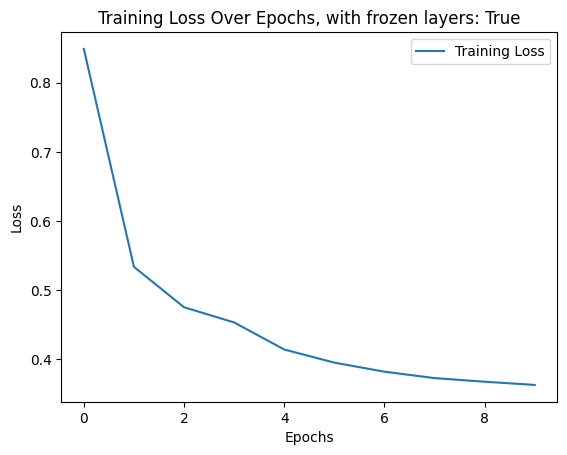

In [ ]:
plot_losses(train_losses_frozen) #OCR

In [ ]:
metric_values_frozen[0].compute() #OCR

{'map': tensor(0.1447),
 'map_50': tensor(0.3447),
 'map_75': tensor(0.0823),
 'map_small': tensor(0.0170),
 'map_medium': tensor(0.1466),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.1498),
 'mar_10': tensor(0.1834),
 'mar_100': tensor(0.1834),
 'mar_small': tensor(0.0290),
 'mar_medium': tensor(0.1839),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 36],
        dtype=torch.int32)}

In [ ]:
metric_values_frozen[-1].compute() #OCR

{'map': tensor(0.4528),
 'map_50': tensor(0.8114),
 'map_75': tensor(0.4537),
 'map_small': tensor(0.1336),
 'map_medium': tensor(0.4554),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.4675),
 'mar_10': tensor(0.5168),
 'mar_100': tensor(0.5168),
 'mar_small': tensor(0.2583),
 'mar_medium': tensor(0.5176),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 36],
        dtype=torch.int32)}

In [ ]:
images, labels = next(iter(val_loader))

In [ ]:
images = [image.to(device) for image in images]
labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

In [ ]:
model.eval()
with torch.no_grad():
  outputs = model(images)

In [ ]:
outputs

[{'boxes': tensor([[ 80.1402, 105.4053, 109.1084, 180.5446],
          [146.9950,  25.2988, 173.6636,  96.7734],
          [ 74.2281,  25.0320, 100.1525,  97.5770],
          [149.8019, 106.4949, 175.9067, 177.0448],
          [115.3072, 107.9483, 137.2047, 175.7267],
          [ 45.8086,  24.4701,  71.0091,  97.6102],
          [ 45.0853, 105.2738,  72.9684, 178.1633],
          [126.1552,  25.3418, 147.9271,  97.4253],
          [ 45.1541,  18.3333,  71.1072, 183.5820],
          [128.8861,  28.0593, 185.6255, 101.2980],
          [ 42.7737, 104.0655,  72.6798, 176.5367],
          [121.7369,  20.2445, 146.9678, 142.2492],
          [121.2677,  26.7934, 146.4261, 104.9350],
          [ 43.3099,  24.8119,  69.2014,  91.1257],
          [114.8827, 110.1037, 134.6170, 177.9013],
          [151.5276, 104.6399, 174.2823, 166.2671],
          [148.0375,  99.4708, 177.1909, 176.2973],
          [123.1437, 108.0386, 130.0851, 178.9786],
          [156.2967, 105.6620, 172.5069, 159.2398],
   

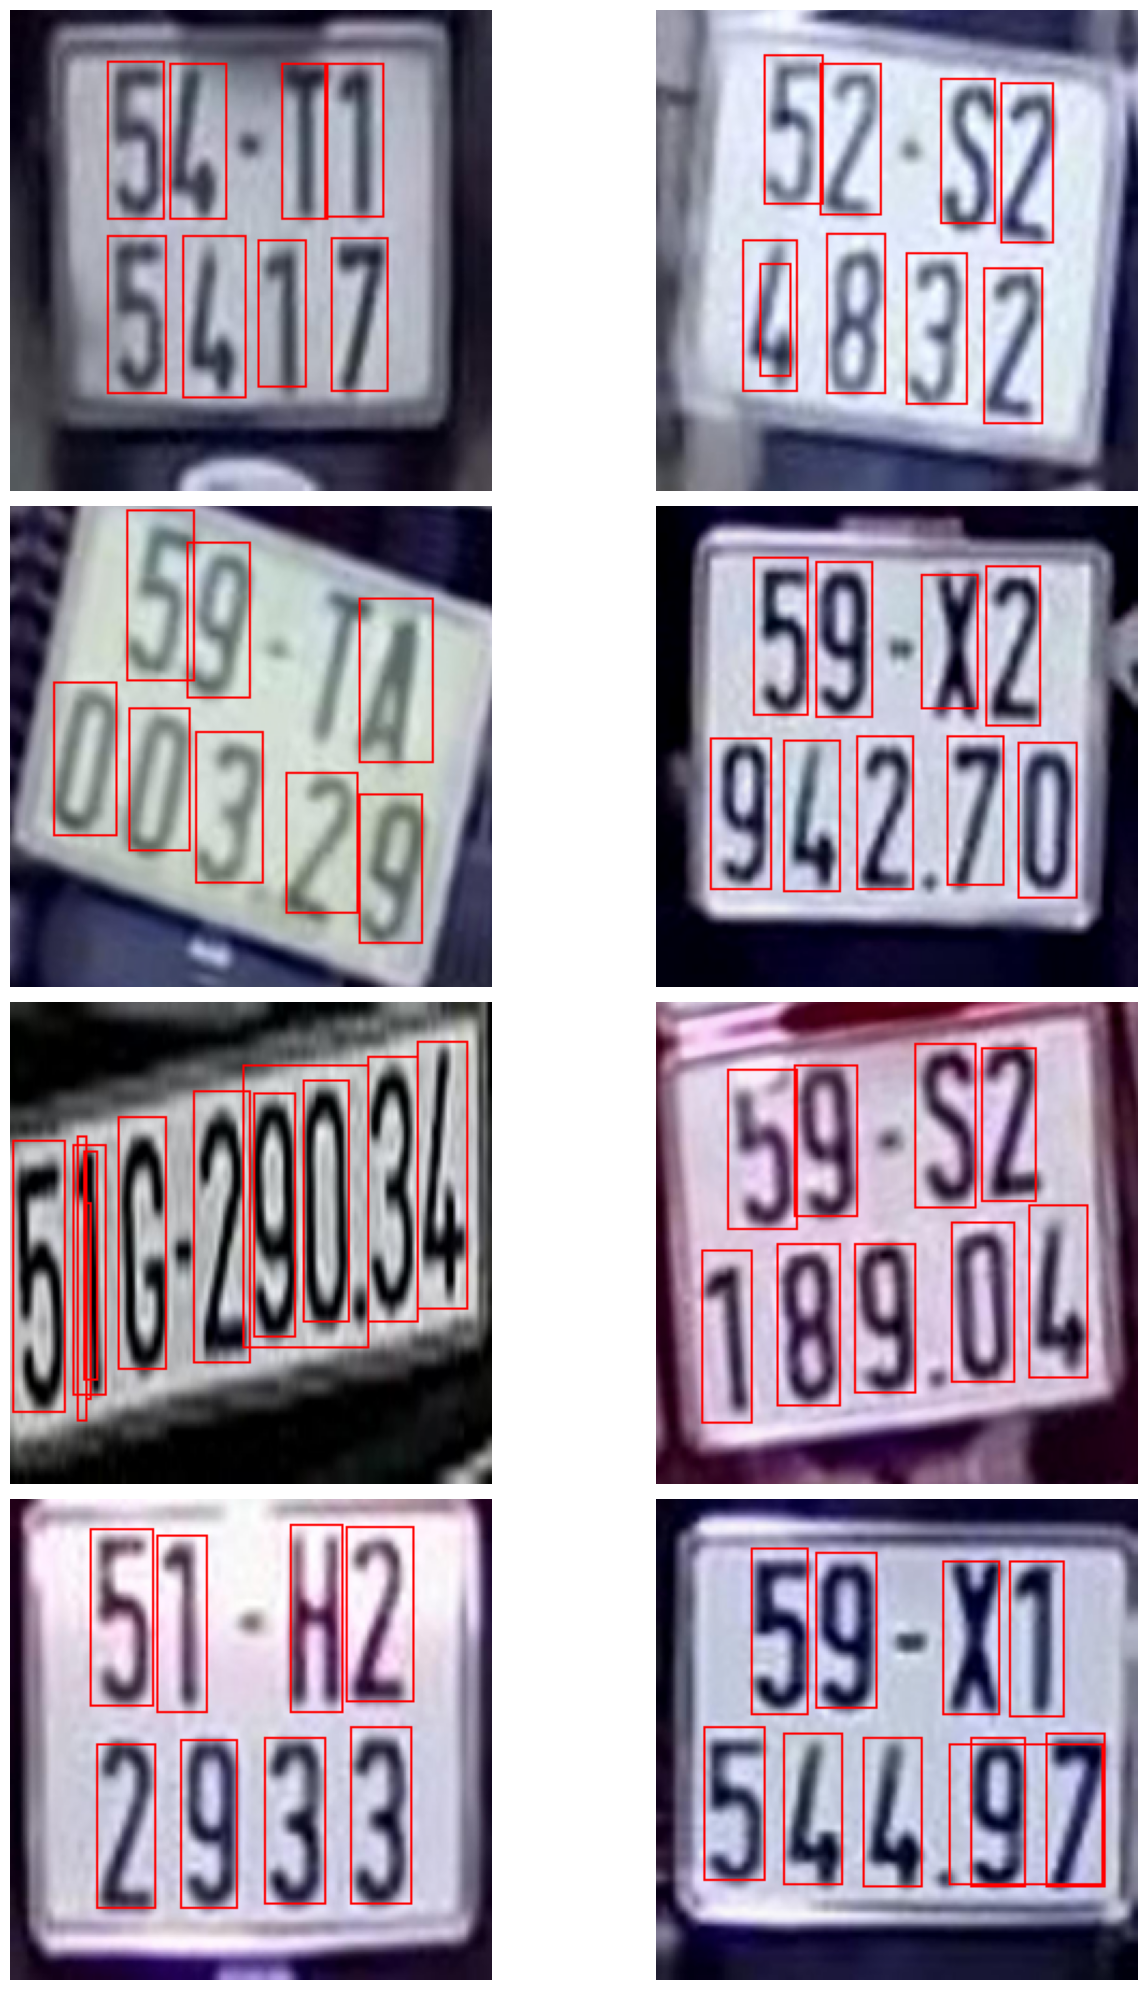

In [ ]:
plot_image_boxes(images, outputs)

In [ ]:
%pwd

'/content'

In [ ]:
#we trained frozen layers, now let's train our model on unfrozen layers
best_model_frozen = torch.load('/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models_number/frozen_att1_epoch8.pt')

In [ ]:
for name, param in best_model_frozen.named_parameters():
  param.requires_grad = True

In [ ]:
optimizer = torch.optim.Adam(best_model_frozen.parameters(), lr=0.0002)
NUM_EPOCHS = 10

In [ ]:
train_losses, metric_values = train(NUM_EPOCHS, best_model_frozen, train_loader, val_loader, device, optimizer, frozen_layers=False)

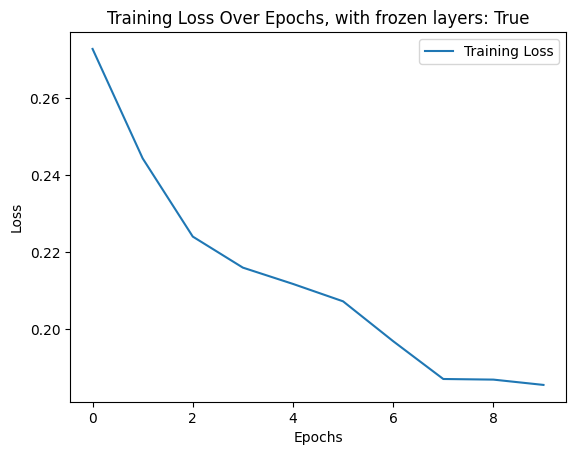

In [ ]:
plot_losses(train_losses)

In [ ]:
#here we just make an inference using fine-tuned models

In [ ]:
model_final = torch.load('/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models_number/att1_epoch8.pt')

In [ ]:
images, labels = next(iter(val_loader))

In [ ]:
images = [image.to(device) for image in images]
labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

In [ ]:
model_final.eval()
with torch.no_grad():
  outputs = model_final(images)


tensor([[ 41,  32,  69, 102],
        [ 68,  29,  95, 102],
        [119,  20, 148,  94],
        [144,  18, 169,  89],
        [ 47, 112,  76, 182],
        [ 83, 109, 110, 182],
        [117, 106, 141, 177],
        [150,  95, 177, 172]]) ['5', '4', 'T', '1', '5', '4', '1', '7']
tensor([[ 55,  10,  85,  83],
        [ 82,  19, 111,  95],
        [135,  39, 163, 109],
        [ 36,  92,  66, 165],
        [163,  44, 191, 120],
        [ 74, 105, 103, 177],
        [111, 117, 141, 188],
        [146, 126, 176, 200]]) ['5', '2', 'S', '4', '2', '8', '3', '2']
tensor([[ 49,  18,  74,  90],
        [ 77,  23, 102,  94],
        [135,  28, 158, 103],
        [ 23,  99,  48, 167],
        [161,  35, 183, 104],
        [ 57, 102,  83, 173],
        [ 93, 108, 118, 180],
        [136, 112, 161, 187],
        [170, 119, 194, 189]]) ['5', '9', 'T', '0', 'A', '0', '3', '2', '9']
tensor([[ 46,  26,  72,  98],
        [ 73,  25,  99,  98],
        [127,  26, 150,  99],
        [154,  27, 180, 102],

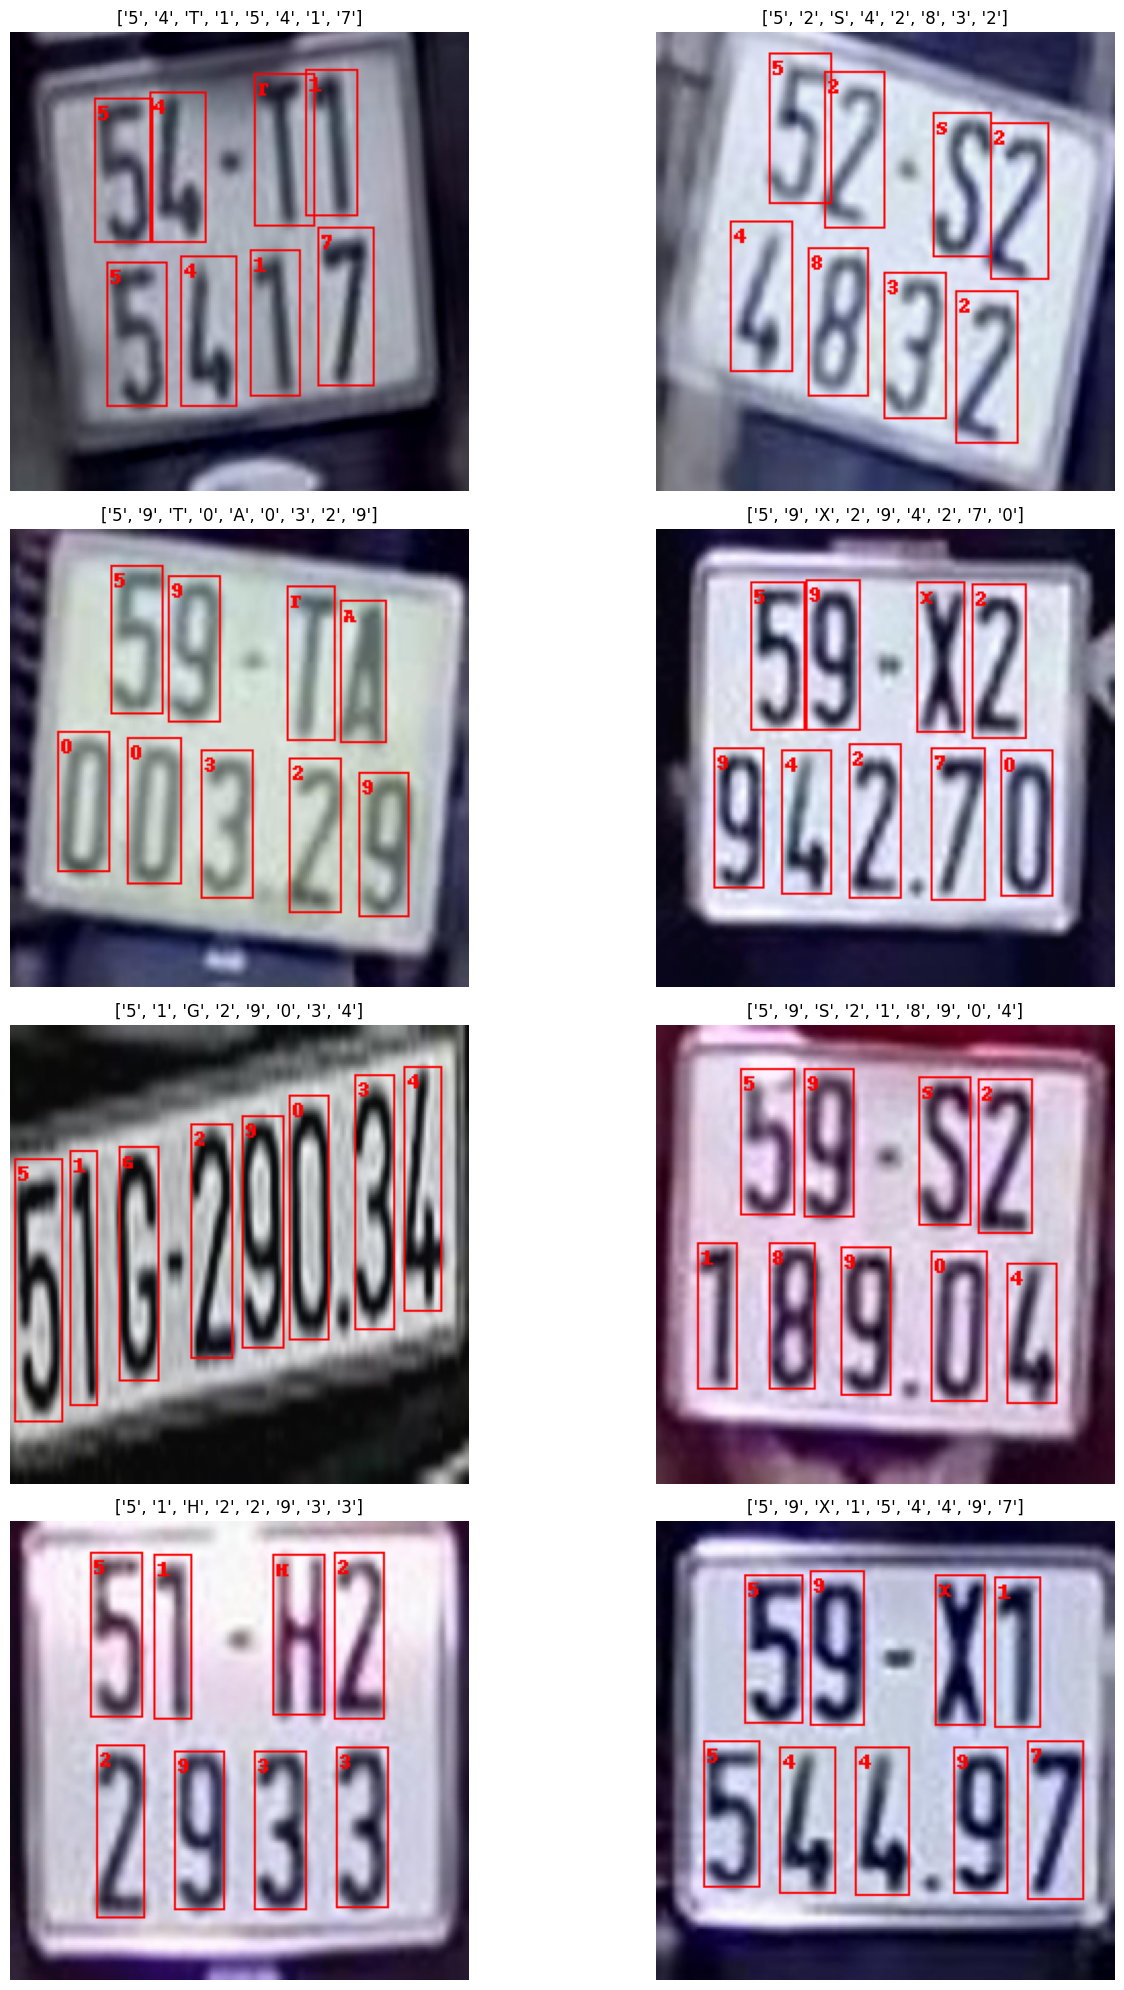

In [ ]:
plot_image_boxes(images, outputs)

In [ ]:
outputs

[{'boxes': tensor([[119.9800,  20.6555, 148.4349,  94.4355],
          [ 41.3464,  32.6376,  69.2238, 102.4974],
          [ 47.3315, 112.2937,  76.6620, 182.7343],
          [150.4165,  95.7021, 177.7030, 172.8774],
          [ 68.3111,  29.6375,  95.2694, 102.9561],
          [144.5405,  18.7049, 169.5391,  89.7277],
          [ 83.2812, 109.1340, 110.9465, 182.8999],
          [117.0506, 106.9880, 141.3422, 177.4691]], device='cuda:0'),
  'labels': tensor([30,  6,  6,  8,  5,  2,  5,  2], device='cuda:0'),
  'scores': tensor([0.9999, 0.9987, 0.9987, 0.9984, 0.9980, 0.9977, 0.9972, 0.9943],
         device='cuda:0')},
 {'boxes': tensor([[ 55.0218,  10.8543,  85.3205,  83.8128],
          [111.2570, 117.0593, 141.0106, 188.4820],
          [ 82.9504,  19.6233, 111.8923,  95.4131],
          [ 74.4684, 105.4349, 103.6223, 177.2118],
          [146.6915, 126.4237, 176.6980, 200.7615],
          [163.4392,  44.7184, 191.1525, 120.8865],
          [ 36.4605,  92.0496,  66.1458, 165.2450],

In [ ]:
letters = {}
for i in range(0, 10):
  letters[str(i+1)] = i

for i in range(ord('A'), ord('Z') + 1):
  letters[str(i - ord('A') + 11)] = chr(i)

In [ ]:
letters

{'1': 0,
 '2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 '6': 5,
 '7': 6,
 '8': 7,
 '9': 8,
 '10': 9,
 '11': 'A',
 '12': 'B',
 '13': 'C',
 '14': 'D',
 '15': 'E',
 '16': 'F',
 '17': 'G',
 '18': 'H',
 '19': 'I',
 '20': 'J',
 '21': 'K',
 '22': 'L',
 '23': 'M',
 '24': 'N',
 '25': 'O',
 '26': 'P',
 '27': 'Q',
 '28': 'R',
 '29': 'S',
 '30': 'T',
 '31': 'U',
 '32': 'V',
 '33': 'W',
 '34': 'X',
 '35': 'Y',
 '36': 'Z'}

# Calculate metrics

In [ ]:
model = torch.load('/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models_number/att1_epoch8.pt')

In [ ]:
metric = test_one_epoch(model, test_loader, device, 0.7, 0.5)

  2%|▏         | 1/60 [00:03<03:12,  3.27s/it]

preds before nms [{'boxes': tensor([[ 50.3702,  21.3389,  72.5655,  97.3927],
        [168.8417, 124.3794, 190.3888, 203.5406],
        [155.8393,  31.6442, 176.4107, 109.9108],
        [ 64.1853, 120.0810,  83.2418, 191.6204],
        [135.8504, 122.9050, 152.5340, 200.0413],
        [129.5764,  29.6316, 148.6839, 106.3071],
        [ 77.9212,  24.2456,  98.7176, 100.9788],
        [ 94.0684, 120.0535, 115.4726, 194.6973],
        [ 30.8101, 114.0391,  51.7154, 189.1652],
        [138.3104, 123.2345, 142.3248, 199.4575],
        [140.3643, 125.5495, 144.5828, 199.7916],
        [139.1426, 128.3920, 147.4014, 192.1300],
        [157.9105,  32.8501, 162.8930, 108.6846]], device='cuda:0'), 'labels': tensor([ 6,  6,  4,  4,  2, 11, 10,  7,  1,  2,  2,  2,  4], device='cuda:0'), 'scores': tensor([0.9991, 0.9990, 0.9988, 0.9978, 0.9946, 0.9939, 0.9913, 0.9903, 0.9901,
        0.2779, 0.0625, 0.0572, 0.0563], device='cuda:0')}, {'boxes': tensor([[ 44.2991,  35.3758,  72.9204, 104.9128],
    

  3%|▎         | 2/60 [00:03<01:31,  1.57s/it]

preds before nms [{'boxes': tensor([[ 61.2444,  55.0539,  82.1422, 165.1516],
        [ 14.5650,  57.9953,  35.3831, 159.7398],
        [121.9281,  56.8421, 140.0471, 164.2342],
        [ 39.9265,  56.6443,  54.0222, 164.0367],
        [199.0063,  45.2757, 217.4612, 151.1676],
        [ 98.1478,  58.9145, 116.8432, 162.7855],
        [177.3651,  47.3979, 190.7938, 154.9597],
        [145.0292,  53.2884, 164.8071, 155.9000],
        [177.6833,  46.1580, 183.6628, 154.1833],
        [182.4288,  44.9314, 187.4160, 153.9111],
        [179.1538,  44.7528, 182.0849, 159.1327],
        [ 41.9086,  62.2487,  49.8204, 157.1845],
        [ 96.8278,  50.9996, 149.2050, 161.6834],
        [ 44.4186,  49.8006,  51.2620, 175.5472]], device='cuda:0'), 'labels': tensor([16,  6,  5,  2,  5,  5,  2,  7,  2,  2,  2,  2,  5,  2],
       device='cuda:0'), 'scores': tensor([0.9986, 0.9974, 0.9961, 0.9961, 0.9956, 0.9954, 0.9947, 0.9924, 0.4567,
        0.1783, 0.1643, 0.1291, 0.0975, 0.0949], device='cuda:0

  5%|▌         | 3/60 [00:04<00:58,  1.03s/it]

preds before nms [{'boxes': tensor([[135.9432, 114.2580, 162.3674, 187.4788],
        [173.1373, 118.7181, 198.0071, 192.4250],
        [ 88.9774, 105.5984, 115.9248, 181.1369],
        [ 43.9322,  15.7740,  68.8986,  87.7088],
        [131.9198,  28.1297, 155.9061, 101.2327],
        [162.7036,  30.2625, 187.7087, 108.7129],
        [ 53.0502, 101.1971,  78.3043, 174.4437],
        [ 16.2959,  97.4266,  36.5950, 171.9315],
        [ 73.7249,  19.3017,  98.1555,  92.0751]], device='cuda:0'), 'labels': tensor([ 6,  6,  6,  6, 29,  3,  7,  2, 10], device='cuda:0'), 'scores': tensor([0.9996, 0.9995, 0.9993, 0.9991, 0.9965, 0.9963, 0.9924, 0.9919, 0.9913],
       device='cuda:0')}, {'boxes': tensor([[ 25.1511, 100.3222,  49.0649, 169.7832],
        [ 50.8395,  24.0961,  73.6198,  92.4477],
        [170.9935, 123.1245, 195.8764, 194.1912],
        [ 60.1109, 108.3843,  83.1057, 176.1467],
        [ 78.9550,  29.4526, 101.9380,  97.5644],
        [164.1167,  41.7686, 180.3990, 110.0996],
   

  7%|▋         | 4/60 [00:04<00:42,  1.31it/s]

preds before nms [{'boxes': tensor([[158.6926, 107.9018, 186.5031, 185.9187],
        [ 86.1387, 124.9367, 114.3299, 199.0914],
        [120.4664, 117.0991, 149.6828, 193.3654],
        [ 50.8702, 130.4519,  82.1028, 203.5261],
        [147.0585,  22.8656, 176.9476,  99.9802],
        [ 66.0981,  40.4908,  94.3341, 114.3800],
        [118.9609,  23.4497, 143.8467, 103.9546],
        [ 40.8048,  41.0529,  68.0007, 120.9625],
        [ 42.5658,  42.8648,  68.8271, 119.4268],
        [ 40.5821,  47.1435,  75.8534, 123.0133],
        [ 46.8404,  42.1371, 105.6656, 117.0690],
        [ 46.8383,  43.5011,  68.5828, 119.7608],
        [120.6171,  22.6148, 144.5366, 103.7001],
        [ 40.5536,  45.2608,  72.9086, 119.6345],
        [ 58.1133,  38.1317,  92.3061, 118.9943],
        [ 39.6086,  41.4614,  69.3567, 119.8510]], device='cuda:0'), 'labels': tensor([ 4,  4,  1,  7,  3,  7, 16,  2, 32, 30,  7, 24, 15,  8,  6, 35],
       device='cuda:0'), 'scores': tensor([0.9998, 0.9997, 0.9989, 0.9

  8%|▊         | 5/60 [00:04<00:34,  1.59it/s]

preds before nms [{'boxes': tensor([[ 66.8248, 134.7080,  94.0947, 208.6091],
        [ 48.5702,  40.7829,  76.5147, 120.0160],
        [ 31.6091, 132.1961,  60.8199, 209.4992],
        [ 99.1172, 131.4895, 128.3229, 210.7145],
        [175.3329, 128.7472, 208.5111, 210.2148],
        [ 77.4984,  43.5146, 105.0028, 119.1707],
        [130.7427,  39.2833, 160.8397, 119.2141],
        [141.7370, 131.6048, 172.6805, 210.5775],
        [158.9203,  40.7971, 184.0544, 120.4662],
        [166.9240,  41.7919, 172.0522, 118.8664],
        [129.1179,  36.1267, 160.5055, 119.4455]], device='cuda:0'), 'labels': tensor([ 4,  6,  3,  9,  6, 10, 16,  7,  2,  2, 26], device='cuda:0'), 'scores': tensor([0.9995, 0.9994, 0.9990, 0.9972, 0.9966, 0.9965, 0.9963, 0.9959, 0.9880,
        0.0697, 0.0571], device='cuda:0')}, {'boxes': tensor([[187.5683, 103.6930, 220.9077, 171.8673],
        [165.1163,  27.2854, 189.7001,  96.4949],
        [ 54.5661, 124.9349,  87.0245, 190.3243],
        [ 66.5478,  42.6965,

 10%|█         | 6/60 [00:05<00:29,  1.84it/s]

preds before nms [{'boxes': tensor([[157.0945,  30.8977, 180.6394, 106.0304],
        [ 49.3186,  43.4564,  74.3088, 115.3336],
        [143.3447, 116.8097, 166.1070, 185.9624],
        [129.8195,  37.2186, 152.0890, 106.1151],
        [ 77.8159,  41.9866, 100.5115, 112.1022],
        [174.9646, 110.4867, 194.2379, 181.7590],
        [ 68.5381, 122.4065,  92.0389, 197.0552],
        [ 39.4984, 124.5884,  63.4090, 198.2847],
        [100.8356, 120.7599, 125.6424, 189.9037],
        [179.6200, 112.7237, 185.0817, 179.1263],
        [ 41.0408, 133.5169,  63.7329, 203.6279],
        [158.3617,  35.3435, 162.6092, 104.8792]], device='cuda:0'), 'labels': tensor([ 3,  6,  4, 29, 10,  2,  8,  3,  9,  2,  5,  3], device='cuda:0'), 'scores': tensor([0.9990, 0.9988, 0.9978, 0.9974, 0.9971, 0.9970, 0.9957, 0.9947, 0.9918,
        0.4651, 0.1471, 0.0822], device='cuda:0')}, {'boxes': tensor([[ 18.0284, 118.6525,  44.7602, 186.4862],
        [ 56.0201, 119.9632,  81.1564, 189.7259],
        [ 40.053

 12%|█▏        | 7/60 [00:05<00:24,  2.14it/s]

preds before nms [{'boxes': tensor([[130.6510,  32.0565, 156.5506, 107.7298],
        [164.6810, 118.2171, 191.4835, 191.9690],
        [ 83.6313, 122.8819, 104.5601, 194.2981],
        [ 36.8400,  39.0698,  64.5187, 111.0673],
        [122.8789, 118.4004, 148.5084, 193.4774],
        [161.6447,  33.3238, 190.0922, 105.3051],
        [ 69.3292,  37.7675,  95.7962, 109.7727],
        [ 43.3571, 125.2796,  67.9853, 192.5432],
        [ 42.9520, 126.3018,  70.1793, 190.9785],
        [164.2197,  31.9957, 192.5069, 107.0279],
        [ 38.1589,  39.3196,  64.7255, 110.7968],
        [ 86.6032, 126.6839,  92.1557, 189.1866]], device='cuda:0'), 'labels': tensor([30,  8,  2,  6,  8,  6,  3,  7,  6,  4,  4,  2], device='cuda:0'), 'scores': tensor([0.9963, 0.9962, 0.9960, 0.9957, 0.9938, 0.9923, 0.9922, 0.9699, 0.0802,
        0.0612, 0.0558, 0.0532], device='cuda:0')}, {'boxes': tensor([[127.7952,  39.7988, 145.9896, 177.5995],
        [ 85.6581,  31.1896, 106.2595, 165.3921],
        [ 20.200

 13%|█▎        | 8/60 [00:05<00:22,  2.32it/s]

preds before nms [{'boxes': tensor([[198.1078,  39.1784, 216.5560, 181.7348],
        [ 86.6820,  49.1961, 105.9423, 185.7934],
        [ 10.5681,  50.7119,  29.0169, 177.3094],
        [113.5168,  53.7378, 130.6873, 183.0392],
        [ 38.4372,  50.0905,  50.6217, 184.2780],
        [135.8908,  48.8204, 156.5298, 181.8466],
        [173.2949,  50.3106, 192.1687, 181.2455],
        [ 39.9813,  53.3301,  43.8410, 177.9226],
        [ 43.0816,  52.7484,  46.6750, 181.6571],
        [170.5903,  49.2046, 193.5079, 183.1508],
        [ 33.6159,  46.3370,  49.2970, 181.1490],
        [137.2309,  46.3053, 158.2392, 182.5049],
        [170.0209,  48.0784, 216.5737, 176.1410]], device='cuda:0'), 'labels': tensor([23,  4, 29,  4, 19,  5, 12, 19, 19, 14,  2, 11, 18], device='cuda:0'), 'scores': tensor([0.9994, 0.9982, 0.9980, 0.9977, 0.9835, 0.9768, 0.9618, 0.8217, 0.5404,
        0.1516, 0.1365, 0.1054, 0.0822], device='cuda:0')}, {'boxes': tensor([[ 77.1363,  27.2767,  98.5472, 106.7029],
    

 15%|█▌        | 9/60 [00:06<00:21,  2.42it/s]

preds before nms [{'boxes': tensor([[ 55.1140,  27.0965,  78.0816,  97.3472],
        [ 46.3714, 111.4771,  71.6750, 178.8701],
        [159.4332,  43.3474, 181.2356, 114.3620],
        [ 82.8101, 114.7107,  99.7932, 183.7079],
        [ 81.7013,  31.6211,  99.3396, 100.2292],
        [152.7147, 125.9564, 169.5762, 196.2985],
        [116.6989, 120.8973, 138.9973, 189.6121],
        [131.8263,  39.5988, 153.8651, 110.4641],
        [ 86.2505, 116.3738,  91.0238, 183.5116],
        [160.9964, 127.4535, 165.6742, 194.1632],
        [ 87.4080, 116.5508,  96.0517, 182.2004],
        [ 84.9607,  33.9380,  89.4839,  98.4886],
        [133.4811,  37.7401, 155.6814, 113.2537],
        [132.2806,  40.0896, 157.6405, 110.2921]], device='cuda:0'), 'labels': tensor([ 6,  3,  4,  2,  2,  2,  7, 28,  2,  2,  2,  2, 12,  3],
       device='cuda:0'), 'scores': tensor([0.9994, 0.9992, 0.9974, 0.9927, 0.9925, 0.9892, 0.9892, 0.9883, 0.2613,
        0.2141, 0.1175, 0.0699, 0.0645, 0.0505], device='cuda:0

 17%|█▋        | 10/60 [00:06<00:20,  2.46it/s]

preds before nms [{'boxes': tensor([[167.9268,  36.6709, 195.1059, 114.6330],
        [ 83.8034,  30.0834, 108.0315, 105.8351],
        [ 52.2129,  32.1418,  80.4137, 102.9254],
        [101.1931, 120.7747, 127.4089, 191.2942],
        [ 31.6178, 115.4302,  59.7935, 185.6238],
        [182.1232, 122.9981, 207.9261, 193.1236],
        [137.2092,  44.8986, 165.2329, 112.6983],
        [ 67.4870, 116.4724,  91.1801, 185.4423],
        [144.6176, 121.3692, 171.5706, 194.9339]], device='cuda:0'), 'labels': tensor([ 3, 10,  6,  5,  3,  8, 22, 10,  8], device='cuda:0'), 'scores': tensor([0.9987, 0.9985, 0.9981, 0.9976, 0.9972, 0.9966, 0.9938, 0.9936, 0.9936],
       device='cuda:0')}, {'boxes': tensor([[ 25.2579, 116.8153,  51.5163, 188.8418],
        [ 98.1054, 115.4331, 124.9329, 184.0404],
        [ 41.4431,  33.4074,  67.8886, 106.7696],
        [159.0054,  31.2683, 185.9773, 102.3098],
        [144.2768, 115.2611, 166.6263, 182.7965],
        [181.9655, 110.8689, 208.9594, 182.0462],
   

 18%|█▊        | 11/60 [00:06<00:19,  2.51it/s]

preds before nms [{'boxes': tensor([[178.3928, 126.5111, 200.5676, 200.7770],
        [134.0196,  46.9042, 157.4767, 112.3448],
        [ 40.4252, 133.0385,  64.0018, 200.1346],
        [106.1775, 131.2425, 127.6376, 201.2064],
        [165.6709,  46.6008, 178.8297, 112.8156],
        [ 73.1168, 131.5092,  95.9915, 198.0853],
        [146.2188, 128.2357, 164.9941, 200.4009],
        [ 58.5906,  46.3393,  77.6520, 119.8877],
        [146.5685, 130.2173, 164.0249, 200.1066],
        [ 86.0763,  46.0633, 104.1200, 118.2724],
        [ 85.0322,  47.3979, 103.9214, 118.9146],
        [ 59.5339,  45.0815,  76.6711, 117.3172],
        [168.4664,  48.0955, 171.9371, 112.9489],
        [170.1849,  53.7929, 173.1110, 114.3526],
        [ 71.6745, 133.5707,  97.1699, 199.3400],
        [ 58.1420,  43.4473,  80.4084, 118.8945]], device='cuda:0'), 'labels': tensor([ 4, 13,  4,  4,  2, 10,  8,  8,  2,  2,  8,  2,  2,  2,  4, 30],
       device='cuda:0'), 'scores': tensor([0.9991, 0.9979, 0.9977, 0.9

 20%|██        | 12/60 [00:07<00:18,  2.57it/s]

preds before nms [{'boxes': tensor([[149.9791, 119.8964, 173.4848, 198.3591],
        [ 44.7064,  26.4649,  67.4524, 102.8309],
        [ 79.9781, 119.3514,  99.8825, 193.6806],
        [152.0551,  31.7082, 173.6606, 105.9041],
        [123.5651,  29.0894, 145.1070, 107.1270],
        [ 41.8998, 117.3438,  59.9775, 194.2347],
        [114.8434, 121.6107, 136.5987, 196.3676],
        [ 72.0677,  27.4255,  89.4326, 103.4712],
        [130.5249,  28.2369, 134.6108, 107.8822],
        [ 81.5667, 122.1088,  86.8222, 194.6135]], device='cuda:0'), 'labels': tensor([ 3,  6,  4,  7, 21,  2, 10,  2, 21,  4], device='cuda:0'), 'scores': tensor([0.9996, 0.9986, 0.9970, 0.9965, 0.9961, 0.9955, 0.9942, 0.9918, 0.1903,
        0.1394], device='cuda:0')}, {'boxes': tensor([[146.4055, 109.8623, 177.3049, 180.1467],
        [ 38.7384,  47.4008,  68.6512, 119.9119],
        [128.6382,  34.5142, 157.1373, 104.1004],
        [ 69.1990,  44.8656,  97.5970, 114.9453],
        [100.0149, 118.5826, 130.2628, 1

 22%|██▏       | 13/60 [00:07<00:18,  2.58it/s]

preds before nms [{'boxes': tensor([[ 34.8176,  44.8825,  69.2521, 116.5504],
        [144.8911, 112.6133, 175.1580, 183.1166],
        [ 60.8020, 121.3767,  92.8988, 195.9000],
        [ 22.8925, 129.5872,  55.3249, 202.8204],
        [ 97.7771, 117.2959, 128.6894, 191.0702],
        [182.2215, 105.6803, 214.2714, 179.1209],
        [ 67.1313,  41.1470,  98.1298, 113.2293],
        [156.9575,  27.2708, 187.9423, 100.7611],
        [125.0156,  34.0189, 156.7536, 102.7066],
        [119.9680,  33.8118, 147.5176, 107.6802]], device='cuda:0'), 'labels': tensor([ 6,  5,  6,  1,  5,  3, 10,  3, 22,  2], device='cuda:0'), 'scores': tensor([0.9998, 0.9994, 0.9994, 0.9988, 0.9983, 0.9982, 0.9981, 0.9976, 0.9961,
        0.0622], device='cuda:0')}, {'boxes': tensor([[ 79.5300, 119.8327, 103.1387, 187.5220],
        [ 45.5440,  39.4449,  69.9088, 104.1380],
        [ 44.5766, 116.6177,  66.9262, 184.1732],
        [ 74.4921,  39.3090,  94.1211, 110.1871],
        [117.1038, 126.8107, 138.4266, 1

 23%|██▎       | 14/60 [00:08<00:17,  2.66it/s]

preds before nms [{'boxes': tensor([[ 29.8639,  37.5801,  65.3268, 119.5142],
        [171.4122, 102.6826, 205.2026, 180.1765],
        [137.4194, 109.9919, 170.7236, 188.9834],
        [ 24.4359, 130.4548,  55.0410, 210.0735],
        [ 92.7554, 117.3002, 125.7503, 196.3902],
        [ 61.2827,  33.3260,  92.3656, 111.8500],
        [146.4540,  16.8903, 171.8035,  95.4237],
        [ 59.4114, 126.7565,  90.5552, 201.5762],
        [118.6538,  21.6209, 152.4061, 103.1574],
        [120.8083,  19.1818, 148.9053, 101.1581],
        [117.9632,  22.4483, 149.7731, 101.3475]], device='cuda:0'), 'labels': tensor([ 6, 10,  5,  8,  1, 10,  2,  7, 23, 24, 18], device='cuda:0'), 'scores': tensor([0.9998, 0.9991, 0.9989, 0.9983, 0.9982, 0.9979, 0.9979, 0.9978, 0.7609,
        0.7386, 0.2871], device='cuda:0')}, {'boxes': tensor([[153.2800,  10.5550, 183.8118,  93.5585],
        [ 46.8426,  32.2087,  76.4475, 112.2780],
        [ 75.6938,  27.3596, 103.7969, 109.4487],
        [126.7143, 112.1361,

 25%|██▌       | 15/60 [00:08<00:15,  2.82it/s]

preds before nms [{'boxes': tensor([[ 56.3341,  25.8076,  79.0490, 159.9864],
        [140.0709,  61.0405, 162.5339, 199.8574],
        [  7.6887,   9.3481,  32.1675, 141.4836],
        [116.7419,  50.3569, 138.2459, 187.5918],
        [195.2314,  87.1330, 218.0567, 222.9028],
        [ 94.8532,  41.9159, 108.6915, 175.0629],
        [171.7977,  80.5616, 191.4611, 211.1998],
        [ 34.8049,  13.5321,  48.6152, 149.4688]], device='cuda:0'), 'labels': tensor([17,  1,  6,  1,  7,  2, 10,  2], device='cuda:0'), 'scores': tensor([0.9993, 0.9987, 0.9980, 0.9973, 0.9970, 0.9966, 0.9963, 0.9940],
       device='cuda:0')}, {'boxes': tensor([[ 57.6232,  78.0557,  79.8030, 220.6159],
        [ 32.6103, 102.4101,  56.2163, 224.0000],
        [167.6100,   0.0000, 189.1561, 102.7112],
        [ 92.0050,  51.9555, 112.6228, 188.7587],
        [138.1773,   0.0000, 160.0857, 138.7284],
        [  6.9917, 127.3769,  32.6587, 224.0000],
        [115.7207,  24.0520, 136.7833, 160.6574],
        [191.47

 27%|██▋       | 16/60 [00:08<00:14,  2.94it/s]

preds before nms [{'boxes': tensor([[191.4263,  22.0416, 209.4270, 133.1941],
        [ 55.9785,  56.1768,  75.5762, 172.8932],
        [ 91.8345,  51.0416, 110.1888, 161.3022],
        [  8.9776,  77.4060,  28.9713, 186.2183],
        [139.2581,  41.9118, 156.8940, 147.7576],
        [167.8537,  29.2003, 186.3712, 139.8662],
        [114.9446,  41.7937, 133.2939, 158.5115],
        [ 36.1665,  70.2007,  46.0648, 181.4648],
        [ 35.3750,  68.9280,  38.4280, 181.1798],
        [ 36.9165,  69.1003,  41.0057, 182.6763],
        [ 37.9441,  67.9555,  39.8938, 179.5183],
        [194.4359,  21.6373, 201.4596, 132.5648],
        [ 95.3234,  48.5673,  99.0960, 160.1598],
        [193.8515,  21.9224, 198.0291, 131.5534],
        [192.1437,  23.4168, 196.4934, 132.6775]], device='cuda:0'), 'labels': tensor([ 4, 16,  1,  6, 10,  8,  8,  2,  2,  2,  2,  4,  1,  4,  4],
       device='cuda:0'), 'scores': tensor([0.9996, 0.9995, 0.9991, 0.9986, 0.9976, 0.9923, 0.9912, 0.9706, 0.5101,
        0

 28%|██▊       | 17/60 [00:08<00:14,  3.06it/s]

preds before nms [{'boxes': tensor([[  6.4996,  69.2898,  26.4522, 193.3723],
        [ 54.0820,  62.5411,  74.0354, 192.1481],
        [139.5588,  50.5159, 159.4719, 182.2986],
        [192.5902,  45.5653, 214.1284, 177.6761],
        [ 91.4101,  63.8389, 110.0120, 189.2059],
        [118.2010,  53.6460, 127.7303, 185.4911],
        [169.6706,  48.1107, 188.6776, 179.4351],
        [ 33.0225,  69.9173,  44.2652, 196.8841],
        [119.9010,  52.4318, 123.1565, 188.4995],
        [141.3060,  54.4643, 146.0716, 183.6549]], device='cuda:0'), 'labels': tensor([ 6, 17,  7,  1,  3,  2,  8,  2,  2,  7], device='cuda:0'), 'scores': tensor([0.9993, 0.9991, 0.9979, 0.9969, 0.9942, 0.9931, 0.9909, 0.9594, 0.1021,
        0.0690], device='cuda:0')}, {'boxes': tensor([[  9.5204,  63.2323,  31.0639, 181.7650],
        [117.4781,  47.2074, 135.0330, 159.8626],
        [140.0126,  47.6631, 159.4144, 155.7202],
        [ 59.4199,  60.7452,  76.9438, 171.7250],
        [ 36.0142,  60.8568,  48.3908, 1

 30%|███       | 18/60 [00:09<00:13,  3.11it/s]

preds before nms [{'boxes': tensor([[ 59.2150,  57.9254,  80.0111, 191.4158],
        [  7.4829,  70.1333,  29.7742, 201.3436],
        [180.0657,  41.5992, 197.2780, 162.6566],
        [123.5361,  45.3710, 144.3209, 177.7837],
        [149.9983,  45.2413, 161.8547, 174.3127],
        [ 37.0105,  66.2462,  47.8424, 197.2904],
        [204.5016,  33.1215, 224.0000, 155.7126],
        [ 97.2283,  54.0296, 116.2421, 183.6270],
        [217.2999,  21.3076, 223.4231, 155.6139],
        [153.7046,  45.8238, 157.9306, 170.2161],
        [212.8217,  33.5236, 215.4131, 143.6897],
        [208.4702,  17.3286, 223.0469, 167.4890],
        [ 61.3212,  57.3680,  70.8717, 190.0969],
        [207.0970,  35.9021, 213.0056, 150.0388],
        [186.6260,  34.0170, 188.9567, 161.0488],
        [203.2918,  12.8298, 217.9100, 170.6252],
        [ 96.8895,  53.4322, 101.4589, 185.3324],
        [205.5776,  39.1814, 210.9029, 157.8033]], device='cuda:0'), 'labels': tensor([16,  6,  5, 10,  2,  2,  3,  5,  3,

 32%|███▏      | 19/60 [00:09<00:13,  3.15it/s]

preds before nms [{'boxes': tensor([[104.8064,  38.1800, 122.1465, 163.1510],
        [ 39.5039,  45.9606,  57.0427, 162.7524],
        [196.0795,  34.5567, 214.2146, 157.2374],
        [146.9951,  39.8715, 164.7946, 156.6464],
        [127.2771,  39.4038, 142.9899, 162.6876],
        [ 16.5878,  39.2687,  35.3838, 163.5754],
        [ 87.3350,  42.1525,  97.9180, 165.4198],
        [174.4962,  37.7711, 191.6832, 154.8546],
        [ 87.6102,  42.6964,  89.7570, 164.2568],
        [ 91.0334,  39.6155,  93.7255, 163.4581],
        [ 92.3368,  41.3440,  95.6847, 161.9413],
        [195.7113,  32.2002, 216.5546, 152.3795],
        [ 89.9131,  42.4317,  92.1457, 161.8565],
        [106.5601,  42.6915, 112.5948, 159.0334],
        [149.6328,  32.5756, 152.7409, 155.1875],
        [180.2574,  38.2294, 185.0739, 156.0557],
        [152.0394,  44.5607, 156.6640, 150.8526]], device='cuda:0'), 'labels': tensor([ 1, 17, 17,  7,  4, 36,  2, 11,  2,  2,  2, 13,  2,  1,  7, 11,  7],
       device='c

 33%|███▎      | 20/60 [00:09<00:12,  3.19it/s]

preds before nms [{'boxes': tensor([[149.1302,  34.5942, 166.0698, 148.3077],
        [ 90.8108,  40.7266, 107.9224, 159.2501],
        [ 27.0826,  54.1804,  45.9406, 174.8642],
        [190.9578,  23.3880, 209.3599, 140.9272],
        [ 49.1476,  47.6966,  68.1245, 175.7308],
        [111.3341,  36.6878, 127.2475, 157.3875],
        [172.3396,  27.1208, 190.3203, 144.2498],
        [132.0261,  34.1883, 142.6554, 156.2983],
        [175.8125,  21.8107, 215.3515, 137.5475],
        [194.3883,  21.7535, 196.9103, 139.6176],
        [180.0754,  25.3993, 194.0530, 142.0969],
        [179.5549,  24.7439, 185.2868, 140.9001],
        [172.6164,  26.2705, 174.6615, 142.2870],
        [103.4119,  35.8661, 137.5194, 158.5715],
        [150.0960,  28.6978, 153.7465, 149.6599],
        [ 48.4769,  43.7344,  69.1373, 178.3298],
        [ 51.4180,  44.4309,  54.5152, 169.0402],
        [ 31.5474,  52.9846,  33.6296, 179.2437]], device='cuda:0'), 'labels': tensor([ 1,  1, 21, 21, 13,  1, 21,  2, 21,

 35%|███▌      | 21/60 [00:10<00:12,  3.04it/s]

preds before nms [{'boxes': tensor([[116.4077,  22.0001, 134.0754, 167.3318],
        [172.2438,  11.8513, 189.0318, 169.0799],
        [ 24.2544,  15.8522,  44.5272, 167.3497],
        [ 48.7121,  17.3207,  65.9174, 173.1525],
        [ 95.2908,  27.8103, 112.4416, 168.9169],
        [137.8663,  17.0505, 155.5700, 176.3545],
        [191.2830,  14.9797, 212.1012, 172.5106],
        [190.8073,  13.1151, 211.6663, 168.2558],
        [191.9488,  18.4398, 211.2931, 168.7352],
        [ 95.5859,  24.7147, 100.4663, 168.4729],
        [ 94.9015,  22.5781,  96.8827, 176.3732]], device='cuda:0'), 'labels': tensor([ 6, 16, 36, 17,  3,  7, 36,  8,  3,  3,  3], device='cuda:0'), 'scores': tensor([0.9993, 0.9984, 0.9979, 0.9978, 0.9978, 0.9978, 0.9964, 0.1303, 0.0755,
        0.0725, 0.0501], device='cuda:0')}, {'boxes': tensor([[142.3169, 110.7580, 167.9273, 181.3837],
        [ 96.8608, 112.8749, 124.2516, 186.1615],
        [ 27.8652, 119.0776,  51.1591, 192.0513],
        [ 42.1218,  30.5564,

 37%|███▋      | 22/60 [00:10<00:12,  2.94it/s]

preds before nms [{'boxes': tensor([[ 42.5497, 113.7191,  66.2540, 196.4301],
        [ 41.9263,  11.8475,  66.7113,  94.9502],
        [120.8135, 113.8341, 145.5851, 191.4725],
        [159.3406, 112.8674, 183.5492, 193.8382],
        [ 81.7185, 112.5651, 106.2062, 194.0303],
        [128.7588,   7.2158, 155.2876,  93.5001],
        [ 71.6374,  13.4502,  94.7502,  97.5155],
        [158.7027,   8.3952, 178.6429,  94.9824]], device='cuda:0'), 'labels': tensor([ 4,  6,  4,  5,  1, 29,  5,  2], device='cuda:0'), 'scores': tensor([0.9996, 0.9993, 0.9992, 0.9989, 0.9986, 0.9985, 0.9984, 0.9982],
       device='cuda:0')}, {'boxes': tensor([[131.8122,  26.8022, 159.2173, 104.9675],
        [ 45.6109,  22.3136,  71.9088,  96.8981],
        [176.2191, 120.3504, 199.8975, 196.7050],
        [137.6240, 117.7400, 162.4028, 194.4748],
        [ 21.2799, 106.5560,  48.4315, 185.0175],
        [ 57.5810, 114.8056,  82.8606, 186.4202],
        [ 75.3991,  23.2344,  98.8625,  99.9278],
        [ 93.25

 38%|███▊      | 23/60 [00:11<00:13,  2.83it/s]

preds before nms [{'boxes': tensor([[ 18.2076,  79.0826,  49.5953, 156.9738],
        [ 82.2144,   9.5957, 110.2749,  88.5512],
        [161.9954,  38.0850, 190.0290, 118.4361],
        [128.6320, 122.0448, 158.4108, 199.7796],
        [ 86.2153, 106.6189, 113.0432, 182.0610],
        [163.0423, 132.5791, 193.5572, 209.6071],
        [ 52.6758,  96.5202,  80.2715, 172.2083],
        [ 54.6138,   3.0509,  82.8226,  77.1248],
        [131.2137,  26.7284, 163.1796, 107.6147],
        [160.0380, 148.8138, 191.5577, 209.5750],
        [ 50.1957,   0.9489,  93.1533,  81.3898],
        [131.7430,  27.5800, 162.3831, 109.9692],
        [ 49.4459,   3.2026,  94.9168,  85.5870]], device='cuda:0'), 'labels': tensor([ 1,  4,  4,  3,  5,  7,  5,  7, 12,  1, 13,  9, 17], device='cuda:0'), 'scores': tensor([0.9993, 0.9988, 0.9984, 0.9982, 0.9944, 0.9932, 0.9925, 0.9883, 0.9870,
        0.2068, 0.2061, 0.0803, 0.0772], device='cuda:0')}, {'boxes': tensor([[ 54.6866,  20.6196,  79.1326,  94.9196],
    

 40%|████      | 24/60 [00:11<00:12,  2.78it/s]

preds before nms [{'boxes': tensor([[ 40.3471,  15.3447,  64.5399,  95.3633],
        [127.5019,  10.0955, 151.2167,  98.1342],
        [ 94.2767, 113.3873, 117.7364, 196.9850],
        [ 70.3578,  13.7114,  92.8672,  97.0894],
        [175.7197, 110.7603, 198.7699, 198.9447],
        [138.7461, 115.4008, 158.6533, 197.0076],
        [ 22.2558, 116.0221,  44.3923, 193.0423],
        [160.3334,  13.6881, 177.0988,  99.4753],
        [ 58.5709, 115.7199,  80.4660, 196.1896],
        [143.7671, 117.9133, 150.6090, 193.5364],
        [159.5963,  15.9674, 164.4070,  97.4859]], device='cuda:0'), 'labels': tensor([ 6, 21,  3, 10,  8,  2, 10,  2, 10,  2,  2], device='cuda:0'), 'scores': tensor([0.9993, 0.9987, 0.9980, 0.9980, 0.9977, 0.9965, 0.9956, 0.9949, 0.9946,
        0.1479, 0.1306], device='cuda:0')}, {'boxes': tensor([[ 38.6693,  25.5323,  63.0454,  99.6627],
        [ 74.5897, 114.0123,  99.3897, 188.7327],
        [ 69.5498,  29.4081,  92.4639, 100.8889],
        [114.6232, 118.4909,

 42%|████▏     | 25/60 [00:11<00:12,  2.71it/s]

preds before nms [{'boxes': tensor([[ 70.0811,  35.7776,  96.2780, 112.1842],
        [126.7979,  33.4396, 155.4522, 106.5800],
        [ 61.7723, 125.0193,  87.3030, 194.8964],
        [ 98.2078, 124.6089, 124.1101, 195.0875],
        [181.1764, 115.5752, 207.0872, 190.0480],
        [ 24.2811, 125.7629,  50.8894, 199.9632],
        [147.6578, 120.4169, 169.0844, 192.4513],
        [161.9636,  32.5694, 181.7753, 104.9034],
        [ 41.8768,  42.2618,  66.3418, 112.7787],
        [153.0290, 122.5920, 161.2223, 186.5044],
        [125.8181,  31.1137, 156.9817, 106.8009],
        [150.2126, 119.1553, 157.8251, 189.7872]], device='cuda:0'), 'labels': tensor([ 6, 16,  1,  5,  8,  1,  2,  2,  9,  2, 15,  2], device='cuda:0'), 'scores': tensor([0.9998, 0.9985, 0.9968, 0.9962, 0.9957, 0.9955, 0.9926, 0.9889, 0.9878,
        0.1562, 0.1309, 0.0955], device='cuda:0')}, {'boxes': tensor([[155.8529, 120.5452, 181.7895, 189.3038],
        [122.6620, 114.9759, 147.0739, 189.8536],
        [ 76.014

 43%|████▎     | 26/60 [00:12<00:12,  2.67it/s]

preds before nms [{'boxes': tensor([[ 44.7179,  41.5259,  73.6289, 112.2179],
        [ 59.8009, 120.0622,  88.4391, 189.5909],
        [140.8440,  41.5809, 167.8725, 112.7809],
        [100.0422, 123.4882, 126.5766, 193.6391],
        [149.4636, 123.6979, 176.4101, 195.5538],
        [ 21.3523, 118.3961,  49.7437, 191.4697],
        [174.1950,  43.3942, 193.8721, 114.2989],
        [187.0711, 126.2367, 214.3408, 194.1191],
        [ 78.0557,  42.0790, 103.3263, 112.2329]], device='cuda:0'), 'labels': tensor([ 6,  1, 16,  5,  3,  8,  2,  5, 10], device='cuda:0'), 'scores': tensor([0.9996, 0.9983, 0.9981, 0.9977, 0.9976, 0.9951, 0.9904, 0.9897, 0.9887],
       device='cuda:0')}, {'boxes': tensor([[ 36.0150, 114.9937,  65.5184, 182.2094],
        [ 38.7062,  40.3823,  68.1060, 106.6204],
        [ 70.8628,  42.1648,  99.1689, 106.9169],
        [121.5819, 115.3007, 152.0456, 183.8218],
        [136.2343,  37.9421, 162.4545, 109.0350],
        [166.2053,  41.6407, 195.2335, 109.3706],
   

 45%|████▌     | 27/60 [00:12<00:12,  2.70it/s]

preds before nms [{'boxes': tensor([[131.6828,  26.4704, 154.8679, 107.4438],
        [ 97.3687, 119.8089, 118.6857, 199.0799],
        [ 55.4103,  17.6997,  77.0964,  96.0249],
        [169.0207, 128.4863, 190.3258, 207.6468],
        [ 33.3962, 114.2451,  54.4086, 190.9399],
        [ 65.6772, 118.5441,  84.9755, 194.2068],
        [159.8903,  28.0189, 175.7748, 110.9389],
        [136.6517, 128.1584, 157.0265, 202.3226],
        [ 82.1049,  23.6272, 102.1302,  99.9269],
        [163.6067,  35.2820, 168.6763, 107.8066],
        [159.8658,  30.5273, 164.2038, 108.8305]], device='cuda:0'), 'labels': tensor([16,  6,  6,  7,  1, 10,  2, 10, 10,  2,  2], device='cuda:0'), 'scores': tensor([0.9995, 0.9993, 0.9992, 0.9962, 0.9947, 0.9933, 0.9896, 0.9873, 0.9738,
        0.1152, 0.0649], device='cuda:0')}, {'boxes': tensor([[ 41.1139,  21.9000,  68.5496,  98.4933],
        [131.4824,  26.3412, 159.7837, 107.1738],
        [ 72.0557,  22.9347,  97.6151, 103.1300],
        [ 54.6715, 115.8647,

 47%|████▋     | 28/60 [00:12<00:11,  2.71it/s]

preds before nms [{'boxes': tensor([[  2.8763,  73.4429,  25.7245, 195.8866],
        [ 54.7346,  61.8964,  74.1297, 183.5106],
        [ 30.8142,  72.0749,  43.8269, 191.7935],
        [117.2699,  55.6717, 136.5031, 169.2537],
        [198.1804,  38.4773, 217.8538, 153.7480],
        [141.2543,  48.6752, 160.4627, 166.4911],
        [173.5643,  42.7438, 192.6195, 161.9521],
        [ 91.0114,  58.7223, 111.6800, 177.2944],
        [ 31.6049,  73.3112,  34.2968, 186.2346],
        [119.9490,  53.1395, 123.7267, 169.7604]], device='cuda:0'), 'labels': tensor([ 6, 16,  2,  3,  9,  5,  9,  4,  2,  3], device='cuda:0'), 'scores': tensor([0.9993, 0.9992, 0.9984, 0.9959, 0.9957, 0.9912, 0.9853, 0.9844, 0.1496,
        0.0569], device='cuda:0')}, {'boxes': tensor([[ 94.1736,  50.4084, 115.3039, 182.1397],
        [ 59.1383,  55.7830,  77.4033, 176.6570],
        [ 11.4085,  46.4991,  31.3540, 172.6520],
        [195.6546,  42.3030, 214.3311, 173.5092],
        [ 37.0647,  48.9779,  48.0193, 1

 48%|████▊     | 29/60 [00:13<00:11,  2.65it/s]

preds before nms [{'boxes': tensor([[ 10.2978,  84.2348,  31.3415, 194.6493],
        [ 59.2325,  77.9612,  78.5778, 190.7785],
        [171.0342,  34.6884, 188.4522, 151.2747],
        [142.3389,  54.2899, 155.1790, 166.4160],
        [ 35.5516,  82.2241,  49.6970, 196.6406],
        [ 94.5111,  81.6639, 113.8658, 181.7988],
        [194.7863,  18.0247, 208.2968, 135.7120],
        [117.4464,  68.0683, 135.9720, 176.0633],
        [ 64.2056,  85.4949,  70.3798, 190.5075],
        [198.6213,  15.9894, 203.9923, 136.9327],
        [145.5318,  56.6326, 151.3605, 162.1194],
        [143.2534,  59.9763, 149.3662, 164.2622],
        [200.1577,  21.9380, 215.3395, 143.1955]], device='cuda:0'), 'labels': tensor([ 6, 11,  5,  2,  2, 10,  2,  7, 11,  2,  2,  2, 22], device='cuda:0'), 'scores': tensor([0.9991, 0.9980, 0.9972, 0.9968, 0.9948, 0.9926, 0.9869, 0.9847, 0.5333,
        0.3713, 0.3554, 0.3450, 0.0879], device='cuda:0')}, {'boxes': tensor([[ 58.6800,  59.9101,  77.1190, 193.8448],
    

 50%|█████     | 30/60 [00:13<00:11,  2.54it/s]

preds before nms [{'boxes': tensor([[ 39.5702,  43.1778,  69.2226, 111.7576],
        [170.1011,  46.1909, 198.2221, 114.7891],
        [138.5109,  45.6215, 165.2075, 114.3719],
        [ 38.8020, 117.9822,  61.4400, 186.5800],
        [124.5343, 121.9814, 144.3967, 186.1148],
        [ 74.6859,  47.3841,  94.3233, 113.1814],
        [168.1953, 119.7934, 194.5730, 185.1978],
        [ 76.9707, 120.1398, 109.0404, 187.2892],
        [ 42.8753, 122.4188,  50.3613, 185.8898],
        [ 76.4847, 120.4067, 107.1486, 189.0468],
        [ 77.1266,  51.1525,  84.8725, 110.6938],
        [128.6671, 125.9381, 134.2335, 182.6480],
        [ 76.1688,  48.5257,  80.3164, 114.6773]], device='cuda:0'), 'labels': tensor([ 6,  3, 23,  2,  2,  2, 10,  8,  2,  3,  2,  2,  2], device='cuda:0'), 'scores': tensor([0.9996, 0.9987, 0.9985, 0.9913, 0.9894, 0.9866, 0.9846, 0.9499, 0.1842,
        0.0961, 0.0823, 0.0659, 0.0654], device='cuda:0')}, {'boxes': tensor([[  9.8597, 123.4436,  42.3069, 189.2767],
    

 52%|█████▏    | 31/60 [00:14<00:12,  2.40it/s]

preds before nms [{'boxes': tensor([[ 37.6233, 115.8920,  69.6168, 188.0903],
        [172.0722, 118.6174, 202.8004, 187.5527],
        [127.7308, 118.7598, 158.3146, 190.0964],
        [172.1604,  41.8581, 201.0135, 109.4732],
        [ 36.6131,  37.0496,  67.1618, 108.9866],
        [137.2531,  40.1259, 167.0950, 108.3016],
        [ 71.6092,  40.0808, 101.8197, 109.6328],
        [ 83.3608, 119.7975, 113.6737, 188.7357],
        [136.0664,  38.0342, 170.2272, 110.5946]], device='cuda:0'), 'labels': tensor([ 4, 10,  3,  7,  8, 32,  7,  5, 35], device='cuda:0'), 'scores': tensor([0.9993, 0.9980, 0.9979, 0.9959, 0.9957, 0.9947, 0.9939, 0.9870, 0.0696],
       device='cuda:0')}, {'boxes': tensor([[ 31.4847,  43.6118,  64.4806, 105.6349],
        [ 67.2366, 115.7574, 102.6161, 179.5735],
        [166.4531,  55.4486, 196.4132, 121.6000],
        [ 24.1323, 109.2304,  55.3968, 174.4202],
        [111.6839, 122.1734, 142.6923, 188.4574],
        [ 66.8755,  47.7417,  98.2821, 111.7155],
   

 53%|█████▎    | 32/60 [00:14<00:11,  2.36it/s]

preds before nms [{'boxes': tensor([[ 59.6941, 124.4196,  89.8139, 197.7861],
        [ 23.2931, 122.7376,  51.4224, 197.0553],
        [ 43.2347,  40.5554,  69.2448, 112.9781],
        [137.5371,  38.6795, 161.9463, 114.1353],
        [100.3287, 123.1991, 127.8624, 197.9096],
        [168.7480,  39.0141, 188.9909, 113.2706],
        [185.4598, 125.2063, 213.2197, 199.2156],
        [147.9552, 125.4809, 175.0162, 197.3224],
        [ 74.5336,  40.2137, 100.4216, 111.5808]], device='cuda:0'), 'labels': tensor([ 6,  1,  6, 30,  3,  2,  8, 10, 10], device='cuda:0'), 'scores': tensor([0.9995, 0.9990, 0.9988, 0.9985, 0.9971, 0.9969, 0.9964, 0.9942, 0.9888],
       device='cuda:0')}, {'boxes': tensor([[184.0125,  92.2289, 220.8789, 166.3705],
        [ 60.9731, 125.2418,  98.1299, 194.2471],
        [ 34.8665,  60.4192,  70.0702, 128.0689],
        [ 23.7613, 136.1122,  59.8805, 202.9870],
        [ 99.5561, 115.0727, 133.1399, 186.1221],
        [127.5374,  35.2734, 162.9671, 105.1469],
   

 55%|█████▌    | 33/60 [00:15<00:11,  2.43it/s]

preds before nms [{'boxes': tensor([[ 35.7017,  38.2042,  67.0674, 104.3494],
        [ 93.7666, 112.2434, 122.0215, 178.3078],
        [180.2352, 110.5755, 208.2761, 175.3355],
        [142.1832, 112.4636, 171.3908, 176.7194],
        [ 68.6472,  36.8568,  96.9649, 104.2807],
        [ 54.5507, 112.3662,  76.3547, 178.2294],
        [163.7955,  40.3603, 182.9257, 103.7342],
        [133.0529,  34.6689, 158.2511, 104.1673],
        [ 13.0431, 117.7196,  44.5241, 178.5319],
        [170.7516,  42.5046, 178.0663, 102.1181],
        [137.4376,  38.8522, 148.1543,  99.4681]], device='cuda:0'), 'labels': tensor([ 6,  4,  5,  7, 10,  2,  2, 35,  8,  2, 35], device='cuda:0'), 'scores': tensor([0.9997, 0.9991, 0.9949, 0.9949, 0.9945, 0.9943, 0.9914, 0.9913, 0.9864,
        0.1196, 0.0922], device='cuda:0')}, {'boxes': tensor([[ 58.4675, 103.4161,  87.0265, 175.0620],
        [ 53.6223,  19.9352,  82.9344,  92.3929],
        [158.1990,  50.8192, 181.9810, 123.8747],
        [ 25.0123,  94.4279,

 57%|█████▋    | 34/60 [00:15<00:10,  2.48it/s]

preds before nms [{'boxes': tensor([[ 56.5892,  66.9888,  75.5626, 175.4624],
        [171.6374,  12.5100, 191.6805, 123.8851],
        [ 91.5651,  51.8928, 112.1461, 162.5378],
        [115.7815,  39.9951, 136.7339, 151.4728],
        [140.6997,  30.9555, 161.4348, 138.9957],
        [ 31.2450,  78.4439,  46.7864, 189.6004],
        [196.2588,   1.8831, 215.9314, 112.0608],
        [  4.6188,  89.0890,  27.2689, 198.3109],
        [ 97.9267,  50.2335, 107.2956, 159.8607],
        [ 32.9060,  79.1398,  37.9616, 185.8243]], device='cuda:0'), 'labels': tensor([11,  6,  3,  3, 10,  2, 10,  7,  3,  2], device='cuda:0'), 'scores': tensor([0.9994, 0.9992, 0.9984, 0.9983, 0.9979, 0.9971, 0.9931, 0.9924, 0.2165,
        0.1028], device='cuda:0')}, {'boxes': tensor([[195.8388,  55.2450, 215.6352, 172.6902],
        [  8.4308,  62.9224,  28.3793, 183.3047],
        [ 93.1131,  66.5893, 112.9443, 178.7905],
        [ 56.6367,  62.6168,  76.4313, 180.3907],
        [119.9693,  57.3161, 130.3201, 1

 58%|█████▊    | 35/60 [00:15<00:10,  2.41it/s]

preds before nms [{'boxes': tensor([[114.7429,  48.2032, 132.1438, 163.7966],
        [197.2501,  50.0594, 216.7827, 162.8077],
        [136.6231,  47.2192, 156.2963, 163.2239],
        [ 37.8614,  53.6044,  58.0963, 161.4807],
        [ 13.7769,  48.5218,  32.4764, 159.2077],
        [ 88.8828,  51.3357, 108.0383, 160.4597],
        [160.9991,  45.2094, 182.4736, 161.7111],
        [164.7867,  49.0965, 183.6389, 152.1903],
        [143.1451,  48.9137, 147.3925, 161.5826]], device='cuda:0'), 'labels': tensor([ 4, 18,  1, 17, 36,  7,  5, 11,  1], device='cuda:0'), 'scores': tensor([0.9996, 0.9988, 0.9987, 0.9979, 0.9943, 0.9927, 0.9782, 0.2870, 0.2763],
       device='cuda:0')}, {'boxes': tensor([[ 66.4556,  34.6535,  92.2293, 109.6839],
        [ 92.5084, 120.3365, 120.6727, 193.6578],
        [153.4572,  27.6412, 174.7741, 101.0307],
        [174.7033, 111.1499, 202.4192, 186.6674],
        [138.5823, 117.9015, 165.5603, 188.8965],
        [ 56.8627, 123.4710,  83.8448, 197.0920],
   

 60%|██████    | 36/60 [00:16<00:09,  2.44it/s]

preds before nms [{'boxes': tensor([[ 42.0086,  31.3033,  69.8198,  99.8362],
        [ 25.0386, 110.5142,  51.6823, 181.5945],
        [160.6418,  26.2820, 182.6010,  99.6428],
        [ 73.3037,  30.8842,  96.9312,  99.4595],
        [143.6102, 108.0888, 170.7256, 178.3317],
        [ 98.1103, 111.0800, 123.4618, 180.2627],
        [179.5320, 104.9388, 207.9519, 179.3876],
        [ 62.3488, 111.5472,  87.6403, 182.0875],
        [132.7931,  30.0334, 156.8728,  97.4817]], device='cuda:0'), 'labels': tensor([ 6,  1,  2, 10,  7,  9, 10, 10, 32], device='cuda:0'), 'scores': tensor([0.9995, 0.9994, 0.9985, 0.9967, 0.9962, 0.9961, 0.9961, 0.9957, 0.9880],
       device='cuda:0')}, {'boxes': tensor([[ 44.9316,  26.2245,  68.7169, 101.6730],
        [129.5443,  27.5645, 155.1183, 105.0830],
        [ 62.1890, 122.1786,  84.3960, 199.5905],
        [ 27.6428, 119.9974,  49.3356, 199.0490],
        [ 96.9872, 118.6930, 121.0531, 197.7314],
        [142.8664, 122.8421, 164.7944, 200.6387],
   

 62%|██████▏   | 37/60 [00:16<00:09,  2.53it/s]

preds before nms [{'boxes': tensor([[ 92.7880, 125.8261, 124.4382, 206.3940],
        [ 58.1867, 128.7424,  88.4317, 204.5688],
        [ 37.9529,  36.4897,  68.5124, 112.8141],
        [ 21.1283, 127.4941,  51.4977, 206.1603],
        [ 69.7434,  34.7536,  97.5070, 113.6910],
        [174.7825, 122.9473, 205.3647, 199.9919],
        [139.3836, 124.7116, 164.6503, 202.2104],
        [126.4064,  34.0219, 157.2412, 112.7250],
        [155.5104,  32.0977, 182.2957, 111.0865],
        [124.4004,  35.9797, 158.2784, 115.6965],
        [ 47.1824, 125.7389, 106.4481, 205.4675],
        [ 94.3273, 137.9344, 125.0652, 205.9890],
        [123.0548,  32.5702, 157.3632, 114.3305]], device='cuda:0'), 'labels': tensor([ 6,  4,  6,  1, 10, 10,  2, 23,  2, 18,  4,  4, 24], device='cuda:0'), 'scores': tensor([0.9998, 0.9998, 0.9995, 0.9990, 0.9982, 0.9977, 0.9962, 0.9941, 0.9918,
        0.0719, 0.0554, 0.0520, 0.0500], device='cuda:0')}, {'boxes': tensor([[ 61.5145, 116.6665,  92.5496, 186.2081],
    

 63%|██████▎   | 38/60 [00:16<00:08,  2.62it/s]

preds before nms [{'boxes': tensor([[ 27.2011,  27.9255,  60.1019, 111.2603],
        [115.5614, 112.7189, 147.1020, 194.7954],
        [154.6251, 105.4579, 188.0953, 188.3495],
        [ 62.2929,  27.4018,  90.8892, 108.5908],
        [ 75.9801, 121.2523, 106.7710, 201.0651],
        [ 32.9968, 123.1218,  67.3509, 204.3156],
        [149.0051,   8.9518, 179.9115,  98.2919],
        [118.7413,  15.3700, 151.2172,  99.8343],
        [124.3903,  16.4683, 151.9327,  95.5946],
        [118.4356,  17.3619, 150.0813,  94.0501],
        [119.8325,  15.4793, 147.9082, 100.1975],
        [  5.4077, 126.0252,  36.5635, 207.4839]], device='cuda:0'), 'labels': tensor([ 6,  4,  4,  3,  5,  7,  8, 30, 16,  8,  2,  8], device='cuda:0'), 'scores': tensor([0.9996, 0.9993, 0.9992, 0.9986, 0.9986, 0.9969, 0.9897, 0.8834, 0.0771,
        0.0752, 0.0543, 0.0533], device='cuda:0')}, {'boxes': tensor([[ 69.4352,  33.6159,  93.6714, 104.9728],
        [157.5771,  35.3078, 181.1589, 106.9367],
        [ 75.968

 65%|██████▌   | 39/60 [00:17<00:07,  2.75it/s]

preds before nms [{'boxes': tensor([[ 41.9563,  32.5643,  67.7614, 105.2889],
        [118.7676, 116.0598, 144.2725, 188.2980],
        [156.4831, 112.2449, 181.6361, 188.0519],
        [ 83.7405, 118.3027, 101.7327, 188.6455],
        [ 46.2019, 119.4235,  68.8380, 188.2182],
        [154.0893,  30.9043, 176.0113, 102.6626],
        [ 71.0105,  32.8311,  94.5840, 107.2902],
        [125.4880,  33.2208, 148.3043,  97.9051],
        [ 86.2132, 123.1907,  92.9213, 186.1827],
        [ 79.4197,  40.7639,  85.2483, 101.3736]], device='cuda:0'), 'labels': tensor([ 6,  6,  3,  2, 10,  4,  4, 29,  2,  4], device='cuda:0'), 'scores': tensor([0.9994, 0.9993, 0.9983, 0.9977, 0.9972, 0.9957, 0.9957, 0.9899, 0.0871,
        0.0567], device='cuda:0')}, {'boxes': tensor([[  2.4752,  26.0115,  26.3580, 146.1079],
        [ 93.6206,  56.3894, 115.3784, 169.5291],
        [117.1003,  59.9246, 141.3939, 180.1128],
        [144.7059,  69.9802, 166.6637, 181.4517],
        [ 54.6120,  37.1583,  78.5277, 1

 67%|██████▋   | 40/60 [00:17<00:07,  2.85it/s]

preds before nms [{'boxes': tensor([[ 17.6996,  99.7969,  41.1562, 223.4406],
        [157.4337,  16.4380, 178.8538, 134.0344],
        [131.4807,  26.3371, 153.9168, 152.8562],
        [ 43.2188,  83.1027,  66.5387, 210.8027],
        [181.2613,   0.5486, 204.2951, 124.1673],
        [105.1724,  40.5975, 127.7348, 172.2632],
        [ 68.9872,  64.4320,  90.4983, 193.4351],
        [ 68.2508,  79.6080,  91.6090, 190.5443],
        [ 67.7534,  66.6114,  92.1618, 194.0991],
        [ 67.5766,  65.4485,  92.3257, 191.1897]], device='cuda:0'), 'labels': tensor([ 6, 10,  7,  7,  9,  5, 29,  6, 17,  7], device='cuda:0'), 'scores': tensor([0.9984, 0.9984, 0.9981, 0.9976, 0.9966, 0.9898, 0.8902, 0.4970, 0.2985,
        0.1437], device='cuda:0')}, {'boxes': tensor([[138.5252,  56.9054, 157.4325, 163.1380],
        [114.9095,  53.6231, 133.0674, 159.8921],
        [ 58.9325,  54.6295,  76.0115, 162.5059],
        [ 12.0505,  51.5590,  30.7400, 159.8455],
        [ 93.4595,  55.4319, 110.4256, 1

 68%|██████▊   | 41/60 [00:17<00:06,  2.80it/s]

preds before nms [{'boxes': tensor([[ 50.0159,  23.8447,  74.9492, 100.2548],
        [158.2500,  21.9416, 183.7115, 100.1392],
        [100.2100, 112.4891, 123.8441, 185.4747],
        [ 33.0282, 113.3661,  52.9987, 186.9291],
        [ 67.7987, 114.0751,  86.2668, 187.3524],
        [ 78.9253,  26.9610, 102.1187,  99.6871],
        [143.1633, 113.2100, 164.9639, 182.6459],
        [175.0195, 109.0870, 197.2966, 183.2356],
        [131.0594,  25.6329, 156.5042,  94.9956],
        [130.7332,  29.7593, 155.8858,  98.7254],
        [ 72.1489, 117.7889,  78.2078, 185.0964],
        [ 69.6951, 116.0157,  76.2473, 186.0179]], device='cuda:0'), 'labels': tensor([ 6,  3,  9,  2,  2, 10, 10,  5, 13,  5,  2,  2], device='cuda:0'), 'scores': tensor([0.9991, 0.9979, 0.9977, 0.9974, 0.9968, 0.9951, 0.9948, 0.9915, 0.8536,
        0.1187, 0.0798, 0.0517], device='cuda:0')}, {'boxes': tensor([[ 96.8745, 117.1440, 122.5306, 195.1275],
        [ 44.5583,  26.8211,  70.2683, 103.2902],
        [134.152

 70%|███████   | 42/60 [00:18<00:06,  2.80it/s]

preds before nms [{'boxes': tensor([[ 70.0354,  17.6962,  95.6357,  98.1057],
        [ 80.8483, 114.4184, 104.5993, 188.5068],
        [130.6016,  19.9576, 154.1078,  95.3139],
        [159.8198,  17.9403, 184.3848,  98.0387],
        [ 43.8828, 112.4189,  63.8653, 191.0889],
        [ 41.1000,  20.0248,  66.0973,  97.6977],
        [160.9446, 110.7009, 183.7799, 186.8811],
        [124.6748, 111.3731, 142.9006, 190.1341],
        [ 47.0665, 112.7607,  56.8913, 187.7722]], device='cuda:0'), 'labels': tensor([ 6,  4, 29,  3,  2,  7, 10,  2,  2], device='cuda:0'), 'scores': tensor([0.9998, 0.9992, 0.9992, 0.9968, 0.9963, 0.9957, 0.9956, 0.9946, 0.0660],
       device='cuda:0')}, {'boxes': tensor([[165.5939,  20.3082, 190.2017, 100.8869],
        [ 25.7229, 111.4938,  55.5445, 190.0430],
        [ 60.0775, 119.6765,  89.9886, 190.5976],
        [ 49.4447,  18.2547,  76.8196,  99.4811],
        [ 79.0875,  17.6589, 103.7673,  99.4414],
        [133.7526,  22.2248, 160.1408, 100.1636],
   

 72%|███████▏  | 43/60 [00:18<00:06,  2.76it/s]

preds before nms [{'boxes': tensor([[ 41.7281,  15.3700,  69.6872,  96.1152],
        [ 17.2117, 111.5359,  44.8795, 194.0948],
        [164.0743,  25.8177, 188.4596, 108.4667],
        [ 72.7474,  20.4529, 100.0865, 101.0578],
        [ 55.5839, 116.1481,  81.5903, 195.8075],
        [ 92.8581, 119.7799, 118.1167, 198.8500],
        [176.1763, 124.4866, 201.5883, 205.2881],
        [133.4437,  23.0309, 156.8153, 105.7484],
        [140.0203, 122.0760, 165.7296, 200.6315],
        [135.9299,  24.7360, 161.0210, 103.2658],
        [167.5403,  25.9258, 174.1346, 109.0043],
        [146.1714,  19.2518, 192.1173, 110.0985]], device='cuda:0'), 'labels': tensor([ 6,  1,  3, 10,  1,  9,  5, 32,  9, 35,  3,  3], device='cuda:0'), 'scores': tensor([0.9995, 0.9985, 0.9981, 0.9971, 0.9967, 0.9953, 0.9951, 0.9942, 0.9935,
        0.1783, 0.0694, 0.0545], device='cuda:0')}, {'boxes': tensor([[136.4892, 114.1984, 163.9806, 190.9391],
        [ 38.7854,  30.1093,  64.2891, 106.1045],
        [121.115

 73%|███████▎  | 44/60 [00:19<00:05,  2.71it/s]

preds before nms [{'boxes': tensor([[ 45.5348,  24.5705,  72.5483, 101.2147],
        [131.3382,  17.3649, 158.7048,  96.5206],
        [145.8663, 108.9477, 170.7402, 184.2402],
        [162.1004,  18.9051, 181.7272,  95.6274],
        [ 30.2300, 117.1123,  54.4732, 191.7810],
        [ 75.5275,  22.8318,  99.8099,  98.1468],
        [101.5179, 113.9398, 126.1417, 187.7348],
        [ 66.0792, 116.4534,  90.6063, 189.6125],
        [182.2477, 107.9777, 202.5652, 181.6295]], device='cuda:0'), 'labels': tensor([ 6, 30,  1,  2,  9, 10,  9,  9,  9], device='cuda:0'), 'scores': tensor([0.9996, 0.9994, 0.9986, 0.9972, 0.9961, 0.9960, 0.9959, 0.9933, 0.9907],
       device='cuda:0')}, {'boxes': tensor([[178.9856, 110.1007, 202.4919, 193.5401],
        [100.6578, 113.9308, 120.3757, 196.0471],
        [160.0706,  10.5421, 181.3258,  94.0981],
        [127.5403,  11.0191, 154.5692,  94.7781],
        [ 61.7127, 117.8822,  87.0472, 195.2121],
        [145.6976, 113.0399, 164.9079, 194.0382],
   

 75%|███████▌  | 45/60 [00:19<00:05,  2.69it/s]

preds before nms [{'boxes': tensor([[134.7179, 106.4186, 166.3835, 172.7693],
        [ 41.6801,  29.2025,  73.0471,  99.0499],
        [ 59.6550, 104.3382,  89.8354, 172.2630],
        [ 93.9154, 105.1851, 123.5221, 174.0623],
        [ 70.3702,  31.4015,  99.6819,  97.7950],
        [170.3848, 105.8570, 202.7186, 175.9966],
        [123.0383,  32.9802, 153.9635,  99.5589],
        [ 27.2030, 103.7810,  56.7805, 172.9415],
        [151.5264,  33.1616, 176.2729,  99.4269],
        [ 11.0895,  21.4488,  42.4787,  94.4026],
        [143.8197,  27.9276, 195.3510, 100.6533],
        [182.8958,  23.5062, 211.2168,  99.1297]], device='cuda:0'), 'labels': tensor([ 1,  6,  1,  1, 10,  3, 12,  1,  2,  8,  2, 29], device='cuda:0'), 'scores': tensor([0.9990, 0.9988, 0.9986, 0.9977, 0.9977, 0.9976, 0.9968, 0.9967, 0.9949,
        0.1557, 0.1114, 0.0683], device='cuda:0')}, {'boxes': tensor([[ 28.6023,  50.3893,  61.8856, 119.1864],
        [184.8219,  99.6307, 217.6665, 163.9121],
        [ 10.873

 77%|███████▋  | 46/60 [00:19<00:05,  2.68it/s]

preds before nms [{'boxes': tensor([[126.9711, 112.0359, 151.2254, 180.7639],
        [168.3202,  39.0163, 193.9947, 107.4990],
        [ 87.4023, 113.8189, 113.5457, 177.1025],
        [166.5076, 113.5391, 186.1773, 180.5972],
        [ 78.3956,  37.5006, 105.6491, 105.3168],
        [ 46.8967,  37.1679,  73.9324, 108.3803],
        [136.2011,  39.2406, 165.4459, 105.1874],
        [ 47.0763, 111.4697,  73.3787, 179.1246],
        [132.5131,  35.9687, 166.8379, 104.2055],
        [ 46.3437,  79.7357,  72.6412, 179.7811],
        [135.3750,  33.9637, 163.5513, 104.4706],
        [163.7607, 111.0858, 193.9528, 181.8721]], device='cuda:0'), 'labels': tensor([ 3,  3,  7,  2, 10,  8, 31,  5, 14,  3,  1, 16], device='cuda:0'), 'scores': tensor([0.9991, 0.9984, 0.9959, 0.9931, 0.9922, 0.9920, 0.9854, 0.8796, 0.2621,
        0.1010, 0.0916, 0.0550], device='cuda:0')}, {'boxes': tensor([[ 13.3934, 117.9311,  42.1252, 185.8443],
        [155.4673,  40.7798, 184.3417, 107.5977],
        [ 62.210

 78%|███████▊  | 47/60 [00:20<00:04,  2.71it/s]

preds before nms [{'boxes': tensor([[162.4378,  42.2597, 191.0741, 114.4524],
        [ 78.5301, 115.3752, 107.5765, 187.5381],
        [ 43.9534,  33.7810,  71.1828, 104.3218],
        [117.9646, 120.8353, 146.7093, 192.3801],
        [157.7738, 122.5238, 185.4604, 188.7555],
        [129.3607,  40.3911, 157.4332, 113.0420],
        [ 74.7008,  36.9971,  95.5285, 106.7371],
        [ 39.1907, 115.6940,  66.1513, 182.1104]], device='cuda:0'), 'labels': tensor([ 6,  6,  6,  3,  1, 22,  2,  5], device='cuda:0'), 'scores': tensor([0.9994, 0.9991, 0.9990, 0.9987, 0.9971, 0.9955, 0.9945, 0.9890],
       device='cuda:0')}, {'boxes': tensor([[145.5062,  35.4112, 164.7090, 141.3682],
        [ 17.8281,  96.5195,  38.3353, 206.9930],
        [ 99.8867,  58.1466, 119.7980, 163.2230],
        [176.3978,  20.1734, 195.0206, 126.1564],
        [ 64.2339,  70.1432,  86.2898, 178.7618],
        [198.1336,   6.5380, 217.6835, 119.8854],
        [123.2350,  46.3555, 142.6185, 151.8378],
        [ 43.76

 80%|████████  | 48/60 [00:20<00:04,  2.78it/s]

preds before nms [{'boxes': tensor([[159.7377, 110.9454, 186.4514, 192.1138],
        [119.0542, 111.1655, 145.4584, 193.0405],
        [ 38.0525, 113.8503,  62.1416, 194.7162],
        [ 37.7030,  17.6131,  63.1745,  96.9906],
        [ 69.0562,  16.8003,  93.5658, 100.0035],
        [ 78.5271, 113.0131, 103.6356, 192.6596],
        [160.4957,  16.7553, 185.3130,  97.1847],
        [127.3742,  14.2947, 157.6744,  95.8542],
        [128.3034,   9.9139, 153.5245,  97.9101]], device='cuda:0'), 'labels': tensor([ 6,  6,  3,  6,  3,  7,  7, 31,  1], device='cuda:0'), 'scores': tensor([0.9998, 0.9997, 0.9990, 0.9987, 0.9980, 0.9980, 0.9973, 0.9845, 0.4622],
       device='cuda:0')}, {'boxes': tensor([[175.9777, 116.8961, 203.4969, 194.8173],
        [ 88.2792, 112.2314, 114.1070, 186.9185],
        [ 11.7409, 104.8871,  33.6862, 182.4825],
        [127.9656,  22.8828, 155.4399, 101.8536],
        [ 34.4764,  13.4597,  61.7109,  92.7989],
        [ 48.9829, 106.4362,  71.3282, 185.1666],
   

 82%|████████▏ | 49/60 [00:20<00:03,  2.84it/s]

preds before nms [{'boxes': tensor([[ 71.6434,  58.5465,  85.4361, 156.9205],
        [ 53.2374,  60.0235,  67.9202, 154.1824],
        [ 90.4119,  58.7045, 104.9691, 157.4864],
        [148.0097,  65.5295, 159.9628, 156.5854],
        [164.3070,  64.1049, 177.2394, 157.9317],
        [180.2461,  67.0727, 193.6273, 161.0427],
        [129.4948,  62.9081, 142.8007, 159.5778],
        [180.4797,  68.8788, 181.9423, 162.0724],
        [152.0020,  70.6735, 154.4514, 157.0177],
        [165.5877,  69.1598, 166.8772, 162.3752],
        [182.6506,  65.1560, 186.0098, 163.6274],
        [180.8650,  69.2755, 183.6747, 162.5034],
        [165.8829,  70.9117, 169.9895, 158.9386],
        [147.7866,  65.9175, 150.8943, 158.1904]], device='cuda:0'), 'labels': tensor([12,  6,  8,  7,  6,  6,  8,  6,  7,  6,  6,  6,  6,  7],
       device='cuda:0'), 'scores': tensor([0.9972, 0.9921, 0.9893, 0.9892, 0.9770, 0.9666, 0.9563, 0.5110, 0.4803,
        0.3353, 0.3043, 0.1438, 0.0801, 0.0728], device='cuda:0

 83%|████████▎ | 50/60 [00:21<00:03,  2.83it/s]

preds before nms [{'boxes': tensor([[145.3431,  89.4710, 164.4571, 186.1757],
        [164.4955,  94.8024, 187.0219, 201.6324],
        [118.9326,  75.0235, 144.1035, 180.6706],
        [100.2754,  69.8527, 121.8040, 167.3489],
        [ 44.7599,  24.8240,  70.6636, 134.1862],
        [118.9249,  84.0520, 214.2315, 193.0455],
        [180.1688,  78.7566, 206.6491, 208.3471],
        [129.4670,  83.9510, 191.7352, 190.9245],
        [ 98.8744,  63.7393, 124.7707, 169.8579],
        [ 34.0676,  35.5942,  85.2346, 133.9089],
        [ 94.6065,  73.5823, 151.7953, 168.4316],
        [102.0257,  72.8246, 123.8384, 165.3086],
        [ 95.5873,  68.4248, 123.6666, 175.2417]], device='cuda:0'), 'labels': tensor([10,  4,  4,  3,  2,  4,  2, 10,  2,  2,  3, 36,  4], device='cuda:0'), 'scores': tensor([0.9989, 0.9968, 0.9528, 0.5241, 0.2710, 0.2551, 0.2282, 0.1864, 0.1104,
        0.0773, 0.0760, 0.0662, 0.0581], device='cuda:0')}, {'boxes': tensor([[158.1561,  88.5011, 173.9095, 195.9583],
    

 85%|████████▌ | 51/60 [00:21<00:03,  2.87it/s]

preds before nms [{'boxes': tensor([[150.5591,  36.1549, 169.3876, 136.7593],
        [170.2539,  28.7143, 188.3377, 134.3662],
        [132.1347,  43.9860, 150.5449, 146.2824],
        [112.1414,  53.6119, 129.1602, 155.0425],
        [ 43.4715,  82.4566,  58.5518, 182.0233],
        [ 77.3214,  71.1647,  94.7280, 169.8503],
        [ 59.4727,  77.0143,  76.0453, 174.4482],
        [ 47.3596,  85.3134,  53.7307, 181.1066],
        [ 42.2036,  79.5441,  45.2132, 182.9315],
        [ 66.4542,  74.5645,  95.3802, 171.1469],
        [ 60.1323,  77.8828,  64.8410, 172.0884],
        [ 80.1684,  73.6220,  85.2454, 164.1447],
        [110.7775,  50.0283, 129.7635, 156.8795]], device='cuda:0'), 'labels': tensor([ 6,  5,  3,  8,  8,  3, 12,  8,  8, 36, 12,  3, 30], device='cuda:0'), 'scores': tensor([0.9987, 0.9984, 0.9959, 0.9944, 0.9940, 0.9918, 0.9917, 0.4851, 0.2114,
        0.1400, 0.1264, 0.0992, 0.0654], device='cuda:0')}, {'boxes': tensor([[1.2045e+02, 4.4168e+01, 1.3748e+02, 1.4926e+0

 87%|████████▋ | 52/60 [00:21<00:02,  2.84it/s]

preds before nms [{'boxes': tensor([[176.1654,  59.0697, 192.9888, 159.0091],
        [139.2483,  63.9017, 155.0113, 159.2355],
        [156.9895,  61.3816, 173.4831, 159.2949],
        [119.2941,  65.3087, 135.6209, 174.7250],
        [120.1673,  63.0317, 136.9487, 164.5332],
        [ 58.0337,  71.4251,  79.7461, 169.2123],
        [ 79.7794,  66.8515,  98.8018, 178.1352],
        [157.5650,  60.2383, 172.9925, 164.8866],
        [ 40.7272,  73.6116,  59.0215, 170.2132],
        [ 79.1984,  73.3100,  98.1126, 182.6220],
        [ 56.8976,  70.0533,  79.9113, 167.7630],
        [ 43.0494,  72.5945,  58.5751, 172.0438]], device='cuda:0'), 'labels': tensor([ 6,  4,  1,  4, 29, 16,  2, 10, 10,  4, 15,  2], device='cuda:0'), 'scores': tensor([0.9990, 0.9875, 0.9656, 0.4000, 0.1117, 0.0887, 0.0830, 0.0768, 0.0728,
        0.0643, 0.0613, 0.0612], device='cuda:0')}, {'boxes': tensor([[ 60.5671,  60.3277,  76.1092, 154.9325],
        [ 43.9589,  63.5697,  58.3807, 153.9400],
        [175.436

 88%|████████▊ | 53/60 [00:22<00:02,  2.86it/s]

preds before nms [{'boxes': tensor([[150.3761,  75.8096, 169.5314, 177.1608],
        [171.9387,  81.1026, 191.7659, 180.1882],
        [129.4776,  72.5264, 147.7690, 171.8897],
        [ 48.5191,  47.1744,  63.8577, 147.4472],
        [107.9703,  66.8766, 126.5534, 163.1592],
        [ 66.6743,  53.8751,  82.7781, 149.5169],
        [ 31.6040,  43.0675,  47.2344, 139.4360]], device='cuda:0'), 'labels': tensor([ 1,  1,  7, 12,  7,  8,  8], device='cuda:0'), 'scores': tensor([0.9992, 0.9987, 0.9986, 0.9981, 0.9962, 0.9940, 0.9904],
       device='cuda:0')}, {'boxes': tensor([[ 77.2064,  58.7190,  99.6799, 168.5439],
        [171.9946,  79.9024, 194.2155, 182.4011],
        [138.0335,  75.7995, 157.3201, 176.1661],
        [ 37.0792,  57.0017,  60.9826, 160.6448],
        [118.5685,  69.6688, 138.8872, 173.6477],
        [ 61.0242,  61.1573,  80.1349, 167.2307],
        [100.3146, 115.5076, 121.5536, 171.5893],
        [156.2333,  76.9271, 172.8803, 181.5420],
        [155.2872,  76.0549

 90%|█████████ | 54/60 [00:22<00:02,  2.78it/s]

preds before nms [{'boxes': tensor([[150.7473,  31.9240, 170.0107, 132.6120],
        [133.2930,  40.7778, 151.3820, 143.8166],
        [115.1131,  52.2596, 134.6305, 153.7552],
        [ 75.3487,  70.0189,  95.6892, 175.5891],
        [ 43.9430,  93.2517,  61.9429, 192.0795],
        [169.0063,  22.7388, 189.0923, 121.8747],
        [ 56.8839,  82.6512,  75.8039, 190.3343],
        [ 55.1517,  80.3470,  79.4890, 186.2548],
        [ 42.7259,  95.6734,  47.4765, 191.6516],
        [118.2001,  55.5671, 122.5823, 151.4303],
        [ 57.1526,  79.8873,  75.6283, 188.4849],
        [108.0370,  53.6847, 150.8243, 155.4992],
        [152.9133,  35.0411, 156.4334, 130.1337]], device='cuda:0'), 'labels': tensor([10,  1,  3,  6,  9, 10,  8, 30,  9,  3,  2,  3, 10], device='cuda:0'), 'scores': tensor([0.9992, 0.9992, 0.9989, 0.9987, 0.9940, 0.9926, 0.4551, 0.4059, 0.2746,
        0.1073, 0.0946, 0.0883, 0.0510], device='cuda:0')}, {'boxes': tensor([[175.6984,  28.2558, 192.3464, 114.1656],
    

 92%|█████████▏| 55/60 [00:23<00:01,  2.80it/s]

preds before nms [{'boxes': tensor([[168.7804,  67.6330, 185.3750, 166.4234],
        [151.2340,  67.7073, 166.4865, 162.8977],
        [115.7501,  65.3961, 130.4056, 158.9119],
        [ 78.0493,  62.0539,  92.2186, 157.1069],
        [ 60.6949,  62.1988,  76.3492, 150.6019],
        [134.7799,  67.2026, 148.3453, 158.8433],
        [ 45.1580,  59.4005,  58.5577, 149.1690],
        [ 79.2382,  63.4759,  81.2833, 155.3355],
        [ 83.3552,  63.9912,  86.4827, 155.5521]], device='cuda:0'), 'labels': tensor([ 8, 10, 10,  8, 12,  7,  9,  8,  8], device='cuda:0'), 'scores': tensor([0.9987, 0.9976, 0.9974, 0.9953, 0.9943, 0.9932, 0.9900, 0.2803, 0.1548],
       device='cuda:0')}, {'boxes': tensor([[ 83.0694,  75.5832,  97.3645, 159.3131],
        [ 45.0617,  89.3022,  62.6002, 172.9793],
        [120.8500,  63.4132, 136.3307, 146.3294],
        [173.8879,  43.4873, 188.4719, 127.2962],
        [ 63.8482,  84.8916,  79.7834, 166.8218],
        [139.0587,  57.9686, 153.4967, 140.7456],
   

 93%|█████████▎| 56/60 [00:23<00:01,  2.83it/s]

preds before nms [{'boxes': tensor([[112.4502,  60.6141, 141.9637, 155.9887],
        [150.2344,  51.7502, 173.4980, 142.4528],
        [ 36.7563,  88.2693,  58.9163, 179.3798],
        [ 74.7741,  77.3922,  99.9385, 168.2183],
        [167.7555,  42.3348, 193.4716, 138.4154],
        [ 53.0870,  82.0137,  81.4696, 174.6759],
        [ 33.9821,  86.7002,  79.0717, 177.8172],
        [131.3701,  54.0072, 157.4709, 144.6161],
        [ 99.2055,  64.8341, 160.7907, 160.7739],
        [155.4433,  51.1248, 162.6967, 142.0632],
        [ 62.6890,  80.2043,  91.6582, 172.3454],
        [ 47.0475,  78.9419, 106.4337, 175.4957],
        [126.7871,  57.3320, 146.5165, 151.8164],
        [141.3598,  56.3345, 159.8592, 147.8204],
        [168.6381,  46.3665, 194.1862, 135.7599],
        [ 33.6779,  88.8954,  57.4130, 174.1479],
        [ 78.1281,  80.6472,  82.3213, 167.6962],
        [162.6230,  48.0476, 188.9576, 139.1283],
        [142.5659,  54.0956, 159.7851, 149.8769],
        [168.8320,  43

 95%|█████████▌| 57/60 [00:23<00:01,  2.78it/s]

preds before nms [{'boxes': tensor([[ 45.9567,  54.2367,  61.2846, 143.0802],
        [176.3348,  72.8040, 189.0926, 170.6665],
        [ 64.9097,  54.5673,  79.0311, 150.0338],
        [ 82.8340,  55.5889,  96.7797, 149.6865],
        [121.0167,  66.3188, 135.1089, 161.2397],
        [140.1123,  65.0548, 151.8848, 167.0225],
        [158.3028,  69.9677, 169.8471, 170.5625],
        [127.0997,  64.6322, 130.1413, 159.1362],
        [ 48.3138,  54.5690,  49.3786, 145.3632],
        [164.2272,  71.7648, 166.6873, 165.4442]], device='cuda:0'), 'labels': tensor([ 7, 10, 12,  1,  4,  2,  2,  4,  7,  2], device='cuda:0'), 'scores': tensor([0.9972, 0.9970, 0.9966, 0.9946, 0.9922, 0.9781, 0.9594, 0.4101, 0.1191,
        0.1114], device='cuda:0')}, {'boxes': tensor([[134.7518,  61.1427, 149.2249, 160.7904],
        [177.9564,  58.9048, 191.7248, 158.5715],
        [160.3679,  61.1074, 172.8529, 158.1024],
        [ 36.9989,  53.8195,  53.5953, 159.1420],
        [117.5080,  60.5066, 129.0145, 1

 97%|█████████▋| 58/60 [00:24<00:00,  2.81it/s]

preds before nms [{'boxes': tensor([[ 87.2913,  65.0369, 102.3880, 159.2771],
        [ 66.1124,  73.5396,  81.9294, 165.6067],
        [145.5314,  54.3642, 159.7147, 142.1541],
        [161.3908,  48.1811, 176.2330, 140.7097],
        [126.8853,  59.8460, 141.3241, 149.7917],
        [ 46.8594,  81.9628,  62.8655, 167.8571],
        [179.8643,  45.5138, 195.2988, 133.7246],
        [163.8839,  50.6577, 170.7991, 140.6336],
        [183.3354,  47.3184, 184.7370, 133.7276],
        [160.0351,  52.3591, 162.5792, 141.3164],
        [ 91.9342,  69.8530,  96.1383, 159.7084],
        [130.0123,  61.0814, 132.4481, 145.6493],
        [183.2034,  51.5152, 190.4964, 131.1134]], device='cuda:0'), 'labels': tensor([ 2, 12, 10,  8,  4, 10,  4,  8,  4,  8,  2,  4,  4], device='cuda:0'), 'scores': tensor([0.9989, 0.9980, 0.9952, 0.9933, 0.9923, 0.9904, 0.9839, 0.8352, 0.5403,
        0.0817, 0.0712, 0.0692, 0.0652], device='cuda:0')}, {'boxes': tensor([[ 59.8901,  64.7186,  75.0403, 164.2248],
    

 98%|█████████▊| 59/60 [00:24<00:00,  2.73it/s]

preds before nms [{'boxes': tensor([[137.4646,  39.8421, 154.6319, 141.0659],
        [ 82.9556,  71.8667, 101.0519, 175.4941],
        [119.4978,  50.5076, 136.6638, 150.8242],
        [154.8109,  30.0534, 171.2601, 132.6396],
        [171.5003,  18.9141, 188.4105, 121.7326],
        [ 47.2400,  94.7968,  62.7634, 197.3620],
        [ 64.6845,  84.0795,  80.9136, 186.1259],
        [122.0483,  48.5090, 124.9691, 147.7715],
        [ 83.1050,  82.9168, 102.7750, 182.8698],
        [ 50.8819,  96.5254,  53.3317, 194.4384],
        [ 63.6120,  83.6040,  82.1687, 191.3773]], device='cuda:0'), 'labels': tensor([ 6, 13,  1,  3,  6,  2, 12,  1, 17,  2, 14], device='cuda:0'), 'scores': tensor([0.9988, 0.9985, 0.9978, 0.9977, 0.9966, 0.9955, 0.9954, 0.3308, 0.1995,
        0.0784, 0.0532], device='cuda:0')}, {'boxes': tensor([[158.5627,  46.4149, 174.3493, 127.7379],
        [ 85.1826,  79.2638, 100.8331, 161.7410],
        [ 47.0319,  93.9721,  61.1302, 173.9084],
        [176.2026,  37.2911,

100%|██████████| 60/60 [00:24<00:00,  2.42it/s]

preds before nms [{'boxes': tensor([[ 45.3046,  83.6664,  61.9516, 166.5118],
        [175.6272,  47.1129, 190.6113, 130.2855],
        [ 84.2819,  75.0740,  98.8857, 157.2339],
        [ 65.2217,  79.1304,  79.9606, 164.9934],
        [142.1643,  56.9235, 154.9168, 138.6069],
        [123.1833,  64.9066, 138.3436, 146.2996],
        [158.2807,  51.8906, 171.8879, 134.4484],
        [ 89.4519,  75.4273,  92.3109, 153.1531],
        [180.4616,  50.0703, 184.2235, 127.3849],
        [163.2902,  49.9512, 166.5089, 132.4069],
        [176.5213,  49.1131, 180.7403, 127.1334],
        [ 88.4271,  75.4011,  94.2758, 155.9714],
        [147.1776,  56.2296, 149.5628, 139.1967],
        [ 65.6400,  78.0816,  67.3808, 164.2121],
        [182.0054,  49.3382, 185.4465, 125.4857]], device='cuda:0'), 'labels': tensor([ 5,  3,  9, 12,  2,  4,  8,  9,  3,  8,  3,  9,  2, 12,  3],
       device='cuda:0'), 'scores': tensor([0.9979, 0.9973, 0.9969, 0.9958, 0.9949, 0.9921, 0.9775, 0.9198, 0.6877,
        0

In [ ]:
metric.compute()

{'map': tensor(0.5786),
 'map_50': tensor(0.8755),
 'map_75': tensor(0.7067),
 'map_small': tensor(0.6345),
 'map_medium': tensor(0.5791),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.5720),
 'mar_10': tensor(0.6348),
 'mar_100': tensor(0.6348),
 'mar_small': tensor(0.6438),
 'mar_medium': tensor(0.6349),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36],
        dtype=torch.int32)}